# Sensitivity Analysis

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re
from cycler import cycler

import fiona
import geopandas as gp
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import collections
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point, Polygon

%matplotlib inline

sns.color_palette()

sns.set_style("white", {"xtick.direction": "in","ytick.direction": "in"})
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

### Setup all file scenarios

The files I am going to load are the ones showed in the table below. This is to know which file correspond to what. I have not added the dates in the file name since they are autogenerated and it is a sanity check for me, but in reality the dates (numbers in front of the file name scenario) don't matter.
![scenarios_info.png](scenarios_info_cost.png)
![scenarios_info_cap.png](scenarios_info_capacity.png)

In [2]:
cwd = os.getcwd()

In [3]:
facility_label = ['Manufacturing', 'Recycling', 'Manufacturing_cap', 'Recycling_cap']
location_label = ['NAICS', '40209']
factor_label_rec = ['05', '1', '2', '5', '10']
factor_label_man = ['0001','05', '1', '2'] # 0 is 0,5

In [4]:
files_list = []
for fac in facility_label:
    for loc in location_label:
        if fac.startswith('Manufacturing'):
            for fac_man in factor_label_man:
                files_list.append(fac+'_'+loc+'_'+fac_man)
        else:
            for fac_rec in factor_label_rec:
                files_list.append(fac+'_'+loc+'_'+fac_rec) 

#### Group the files into smaller bins for easier handling

In [5]:
recycling_files = [x for x in files_list if x.startswith('Recycling')]
recycling_files_cap = [x for x in recycling_files if "cap" in x]
recycling_files_cost = [x for x in recycling_files if "cap" not in x]

In [6]:
manufacturing_files = [x for x in files_list if x.startswith('Manufacturing')]
manufacturing_files_cap = [x for x in manufacturing_files if "cap" in x]
manufacturing_files_cost = [x for x in manufacturing_files if "cap" not in x]

#### Dictionary to change year number to actual years

In [7]:
year_list = list(range(2025, 2051, 1))
number_year = list(range(1, 27, 1))
years_dict = dict(zip(number_year,year_list))


#### Load plant files

##### Recycling cost

In [8]:
for files in recycling_files_cost:
    testfile_path = glob.glob(os.path.join(cwd, "scenarios_after_update", files, 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path) 
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))

Recycling_NAICS_05: 81 locations
Recycling_NAICS_1: 81 locations
Recycling_NAICS_2: 81 locations
Recycling_NAICS_5: 81 locations
Recycling_NAICS_10: 81 locations
Recycling_40209_05: 81 locations
Recycling_40209_1: 81 locations
Recycling_40209_2: 81 locations
Recycling_40209_5: 81 locations
Recycling_40209_10: 81 locations


Some of the manufacturing files have no solution, so we remove them:

##### Manufacturing cost

In [9]:
for files in manufacturing_files_cost:
    testfile_path = glob.glob(os.path.join(cwd, "scenarios_after_update", files, 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path) 
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))

Manufacturing_NAICS_0001: 187 locations
Manufacturing_NAICS_05: 166 locations
Manufacturing_NAICS_1: 166 locations
Manufacturing_NAICS_2: 166 locations
Manufacturing_40209_0001: 177 locations
Manufacturing_40209_05: 166 locations
Manufacturing_40209_1: 166 locations
Manufacturing_40209_2: 166 locations


##### Recycling capacity

In [10]:
for files in recycling_files_cap:
    testfile_path = glob.glob(os.path.join(cwd, "scenarios_after_update", files, 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path)
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))    

Recycling_cap_NAICS_05: 161 locations
Recycling_cap_NAICS_1: 81 locations
Recycling_cap_NAICS_2: 41 locations
Recycling_cap_NAICS_5: 17 locations
Recycling_cap_NAICS_10: 9 locations
Recycling_cap_40209_05: 161 locations
Recycling_cap_40209_1: 81 locations
Recycling_cap_40209_2: 41 locations
Recycling_cap_40209_5: 17 locations
Recycling_cap_40209_10: 9 locations


##### Manufacturing capacity

In [11]:
manufacturing_files_cap.remove('Manufacturing_cap_NAICS_0001')
manufacturing_files_cap.remove('Manufacturing_cap_NAICS_05') 
manufacturing_files_cap.remove('Manufacturing_cap_40209_0001')
manufacturing_files_cap.remove('Manufacturing_cap_40209_05') 

In [12]:
for files in manufacturing_files_cap:
    testfile_path = glob.glob(os.path.join(cwd, "scenarios_after_update", files, 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path)
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))    

Manufacturing_cap_NAICS_1: 166 locations
Manufacturing_cap_NAICS_2: 83 locations
Manufacturing_cap_40209_1: 166 locations
Manufacturing_cap_40209_2: 83 locations


##### Overlapping locations

In [13]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [14]:
print('40209 overlap x0.5 cost:', len(intersection(Recycling_40209_05_plants['location name'].unique(), 
                                              Manufacturing_40209_05_plants['location name'].unique())))
print('40209 overlap x1 cost:', len(intersection(Recycling_40209_1_plants['location name'].unique(), 
                                              Manufacturing_40209_1_plants['location name'].unique())))
print('40209 overlap x2 cost:', len(intersection(Recycling_40209_2_plants['location name'].unique(), 
                                              Manufacturing_40209_2_plants['location name'].unique())))
print('NAICS overlap x0.5 cost:', len(intersection(Recycling_NAICS_05_plants['location name'].unique(), 
                                              Manufacturing_NAICS_05_plants['location name'].unique())))
print('NAICS overlap x1 cost:', len(intersection(Recycling_NAICS_1_plants['location name'].unique(), 
                                              Manufacturing_NAICS_1_plants['location name'].unique())))
print('NAICS overlap x2 cost:', len(intersection(Recycling_NAICS_2_plants['location name'].unique(), 
                                              Manufacturing_NAICS_2_plants['location name'].unique())))
print('40209 overlap x1 capacity:', len(intersection(Recycling_cap_40209_1_plants['location name'].unique(), 
                                              Manufacturing_cap_40209_1_plants['location name'].unique())))
print('40209 overlap x2 capacity:', len(intersection(Recycling_cap_40209_2_plants['location name'].unique(), 
                                              Manufacturing_cap_40209_2_plants['location name'].unique())))
print('NAICS overlap x1 capacity:', len(intersection(Recycling_cap_NAICS_1_plants['location name'].unique(), 
                                              Manufacturing_cap_NAICS_1_plants['location name'].unique()))),
print('NAICS overlap x2 capacity:', len(intersection(Recycling_cap_NAICS_2_plants['location name'].unique(), 
                                              Manufacturing_cap_NAICS_2_plants['location name'].unique())))


40209 overlap x0.5 cost: 72
40209 overlap x1 cost: 79
40209 overlap x2 cost: 81
NAICS overlap x0.5 cost: 79
NAICS overlap x1 cost: 81
NAICS overlap x2 cost: 81
40209 overlap x1 capacity: 79
40209 overlap x2 capacity: 37
NAICS overlap x1 capacity: 81
NAICS overlap x2 capacity: 37


### Selected locations plot

In [15]:
rec_cap_locs_data = [['Capacity', 'Recycling', 'NAICS', 0.5, 161], 
                     ['Capacity', 'Recycling','NAICS',1, 81], 
                     ['Capacity', 'Recycling','NAICS',2, 41],
                     ['Capacity', 'Recycling','NAICS',5, 17],
                     ['Capacity', 'Recycling','NAICS',10, 9],
                     ['Capacity', 'Recycling', '40209', 0.5, 161], 
                     ['Capacity', 'Recycling','40209',1, 81], 
                     ['Capacity', 'Recycling','40209',2, 41],
                     ['Capacity', 'Recycling','40209',5, 17],
                     ['Capacity', 'Recycling','40209',10, 9],
                     ['Cost', 'Recycling', 'NAICS',0.5, 81], 
                     ['Cost', 'Recycling','NAICS',1, 81], 
                     ['Cost', 'Recycling','NAICS',2, 81],
                     ['Cost', 'Recycling','NAICS',5, 81],
                     ['Cost', 'Recycling','NAICS',10, 81],
                     ['Cost', 'Recycling', '40209',0.5, 81], 
                     ['Cost', 'Recycling','40209',1, 81], 
                     ['Cost', 'Recycling','40209',2, 81],
                     ['Cost', 'Recycling','40209',5, 81],
                     ['Cost', 'Recycling','40209',10, 81],
                     ['Capacity', 'Manufacturing', 'NAICS',1, 166],
                     ['Capacity', 'Manufacturing', 'NAICS',2, 83],
                     ['Capacity', 'Manufacturing', '40209', 1, 166],
                     ['Capacity', 'Manufacturing', '40209', 2, 83],
                     ['Cost', 'Manufacturing', 'NAICS',0.001, 187],
                     ['Cost', 'Manufacturing', 'NAICS',0.5, 166],
                     ['Cost', 'Manufacturing', 'NAICS',1, 166],
                     ['Cost', 'Manufacturing', 'NAICS',2, 166],
                     ['Cost', 'Manufacturing', '40209',0.001, 177],
                     ['Cost', 'Manufacturing', '40209',0.5, 166],
                     ['Cost', 'Manufacturing', '40209',1, 166],
                     ['Cost', 'Manufacturing', '40209',2, 166]]

rec_cap_locs_data_df = pd.DataFrame(rec_cap_locs_data, columns=['Analysis', 'Facility', 'Location group','Factor', 'Selected locations'])

In [16]:
rec_cap_locs_data_df.loc[rec_cap_locs_data_df['Facility'] == 'Recycling'  ]

Analysis   Facility Location group  Factor  Selected locations
0   Capacity  Recycling          NAICS     0.5                 161
1   Capacity  Recycling          NAICS     1.0                  81
2   Capacity  Recycling          NAICS     2.0                  41
3   Capacity  Recycling          NAICS     5.0                  17
4   Capacity  Recycling          NAICS    10.0                   9
5   Capacity  Recycling          40209     0.5                 161
6   Capacity  Recycling          40209     1.0                  81
7   Capacity  Recycling          40209     2.0                  41
8   Capacity  Recycling          40209     5.0                  17
9   Capacity  Recycling          40209    10.0                   9
10      Cost  Recycling          NAICS     0.5                  81
11      Cost  Recycling          NAICS     1.0                  81
12      Cost  Recycling          NAICS     2.0                  81
13      Cost  Recycling          NAICS     5.0                  81
14      Cost  Recycling          NAICS    10.0                  81
15      Cost  Recycling          40209     0.5                  81
16      Cost  Recycling          40209     1.0                  81
17      Cost  Recycling          40209     2.0                  81
18      Cost  Recycling          40209     5.0                  81
19      Cost  Recycling          40209    10.0                  81

#### Recycling

[Text(0.5, 1.0, 'Recycling')]

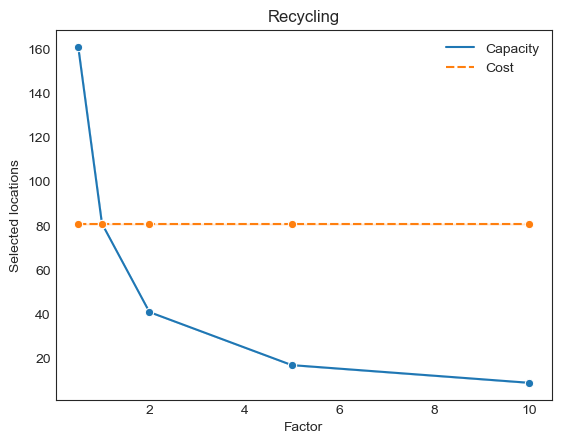

In [17]:
figure = sns.lineplot(x='Factor', y='Selected locations', data=rec_cap_locs_data_df.loc[rec_cap_locs_data_df['Facility'] == 'Recycling'], marker='o', hue='Analysis', style="Analysis", )
figure.legend(frameon=False)
figure.set(title='Recycling')

#### Manufacturing

[Text(0.5, 1.0, 'Manufacturing')]

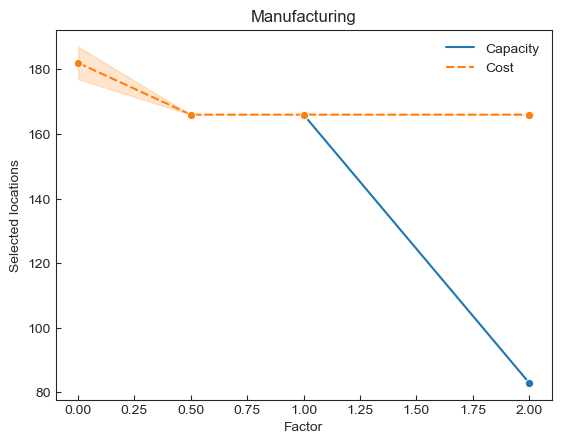

In [31]:
figure = sns.lineplot(x='Factor', y='Selected locations', data=rec_cap_locs_data_df.loc[rec_cap_locs_data_df['Facility'] == 'Manufacturing'], marker='o', hue='Analysis', style="Analysis", )
figure.legend(frameon=False)
figure.set(title='Manufacturing')

### Grid plot

#### Recycling Capacity Utilization Factor

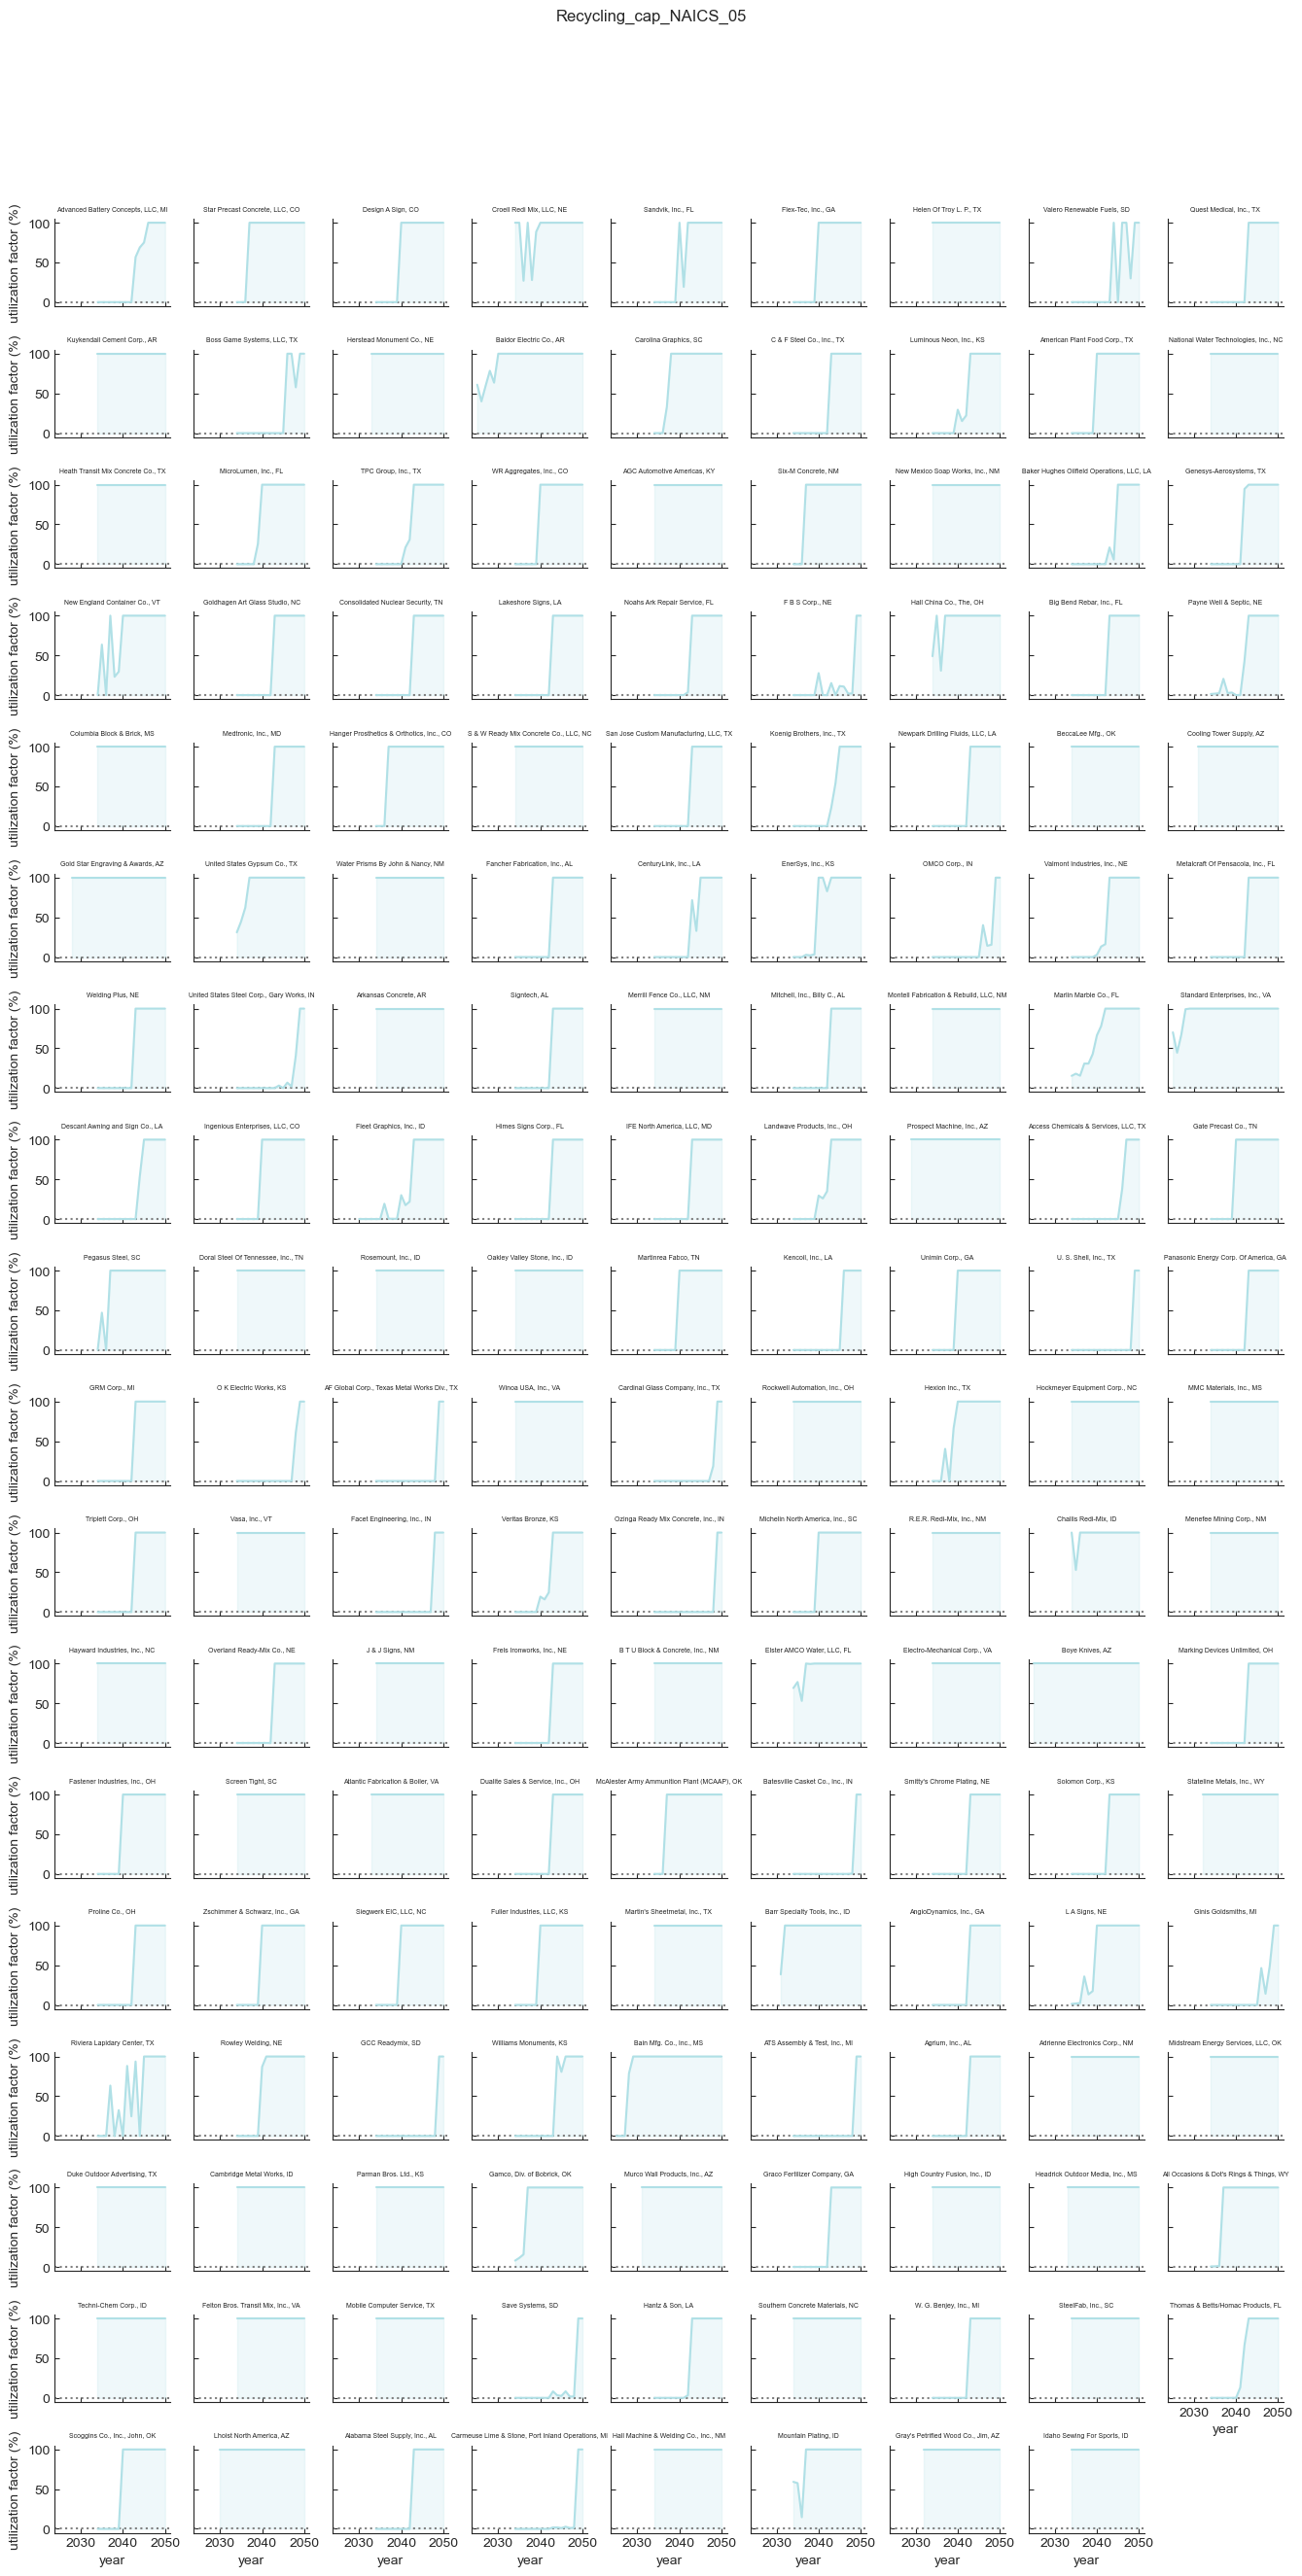

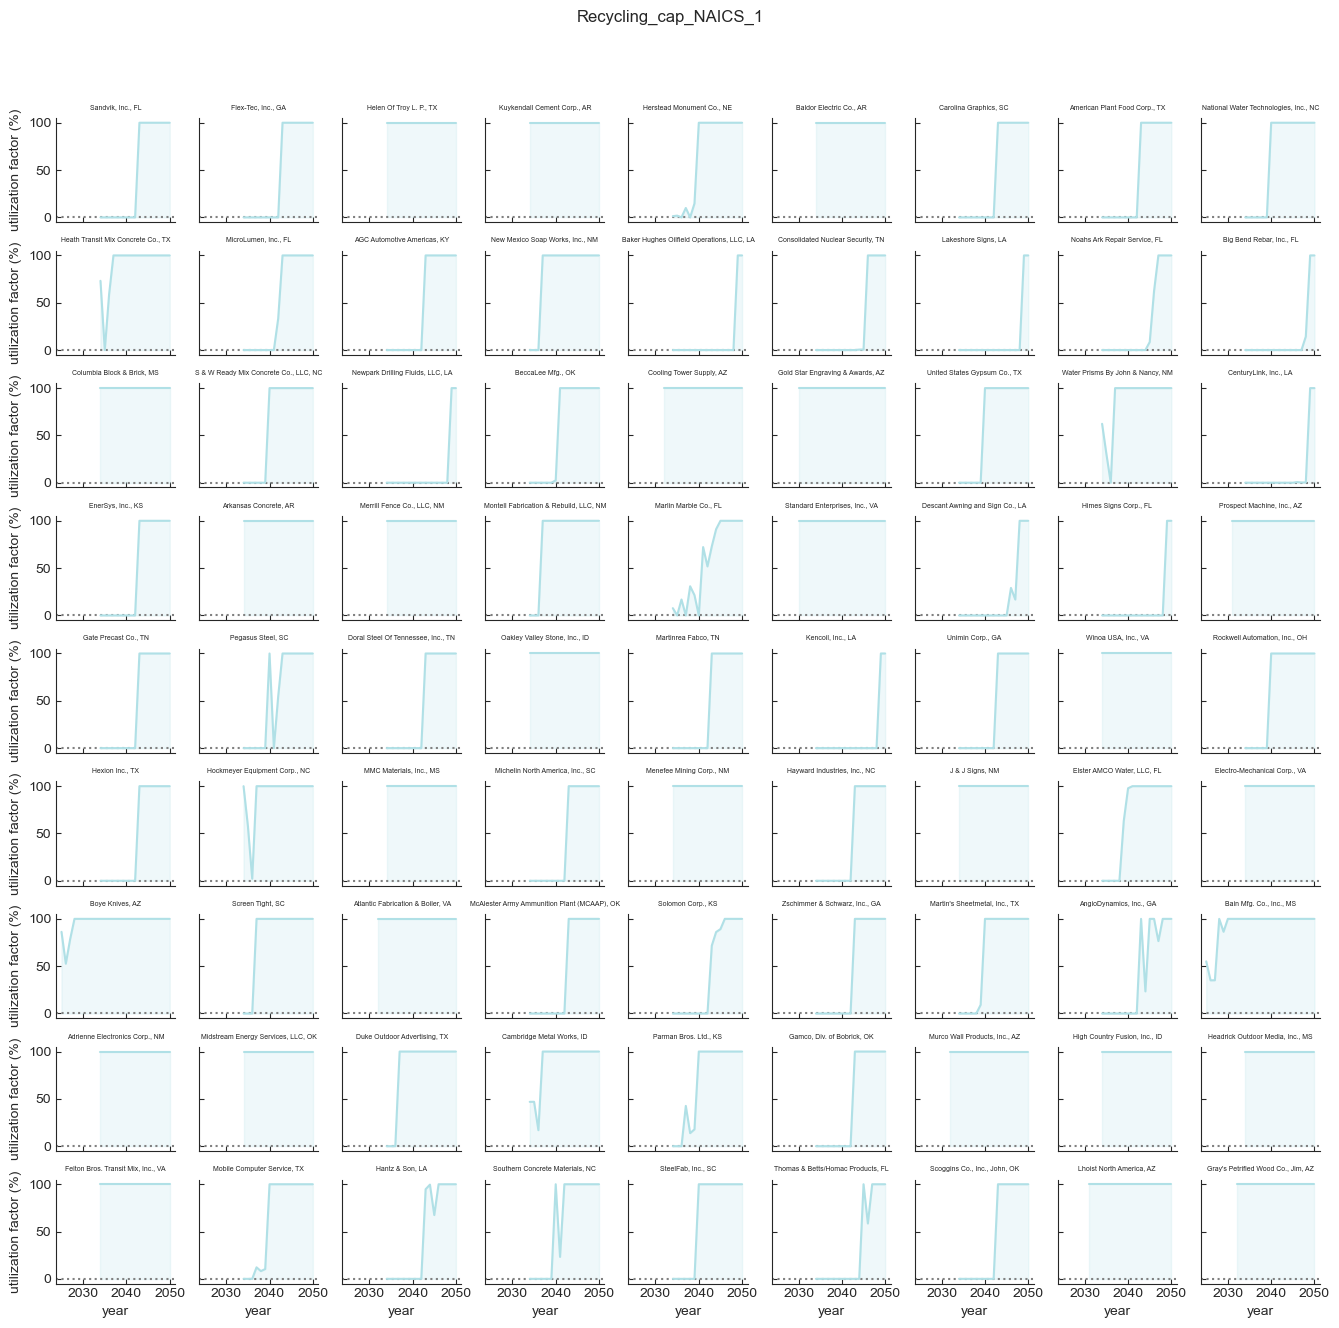

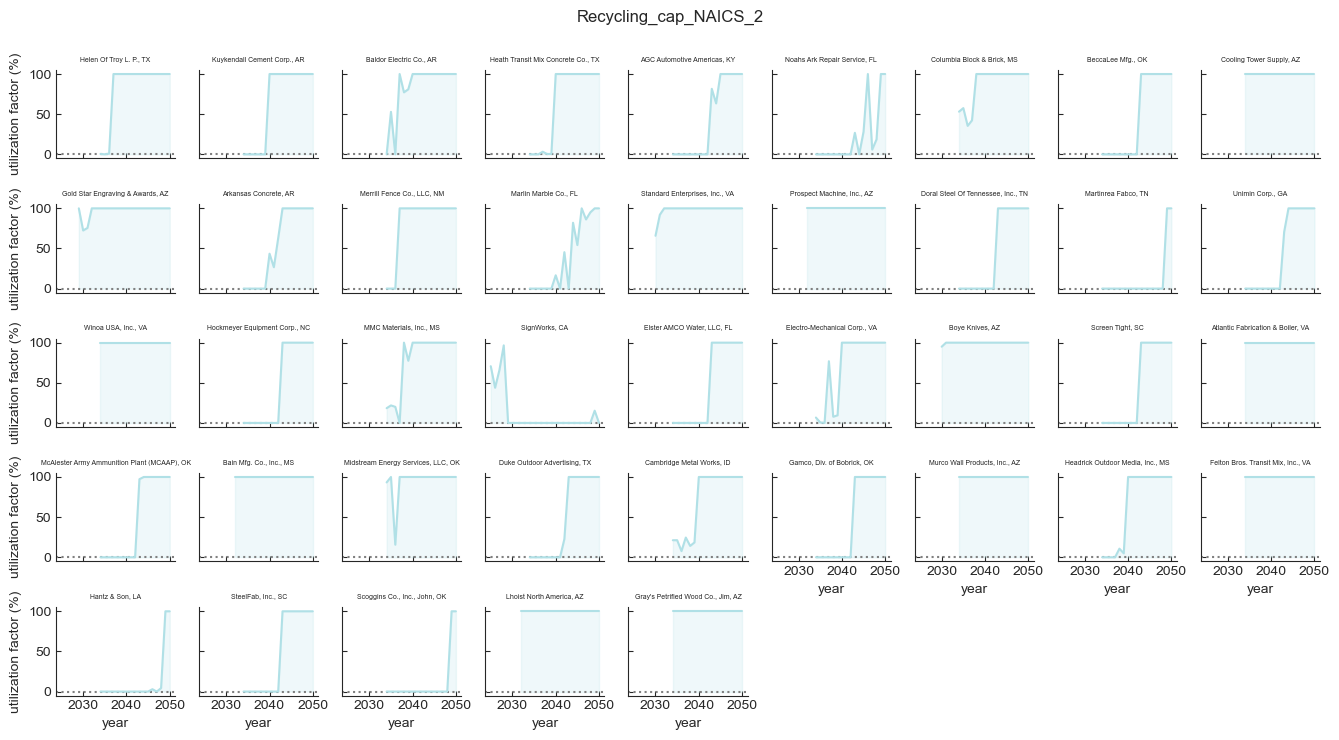

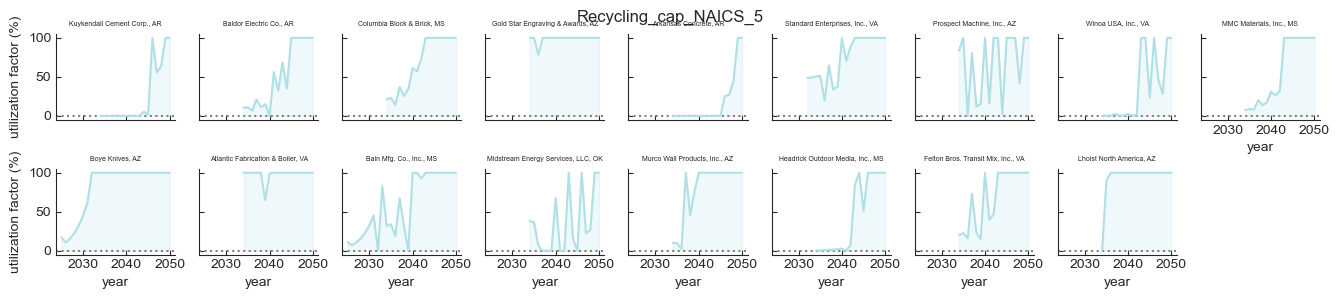

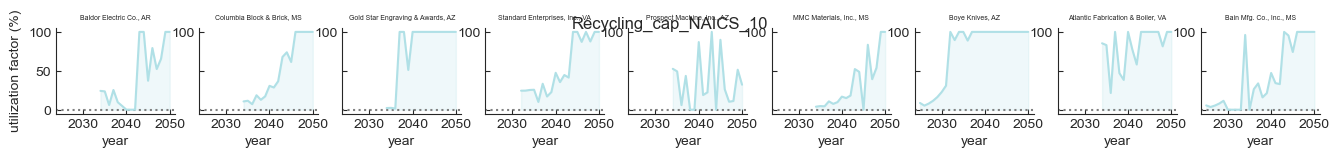

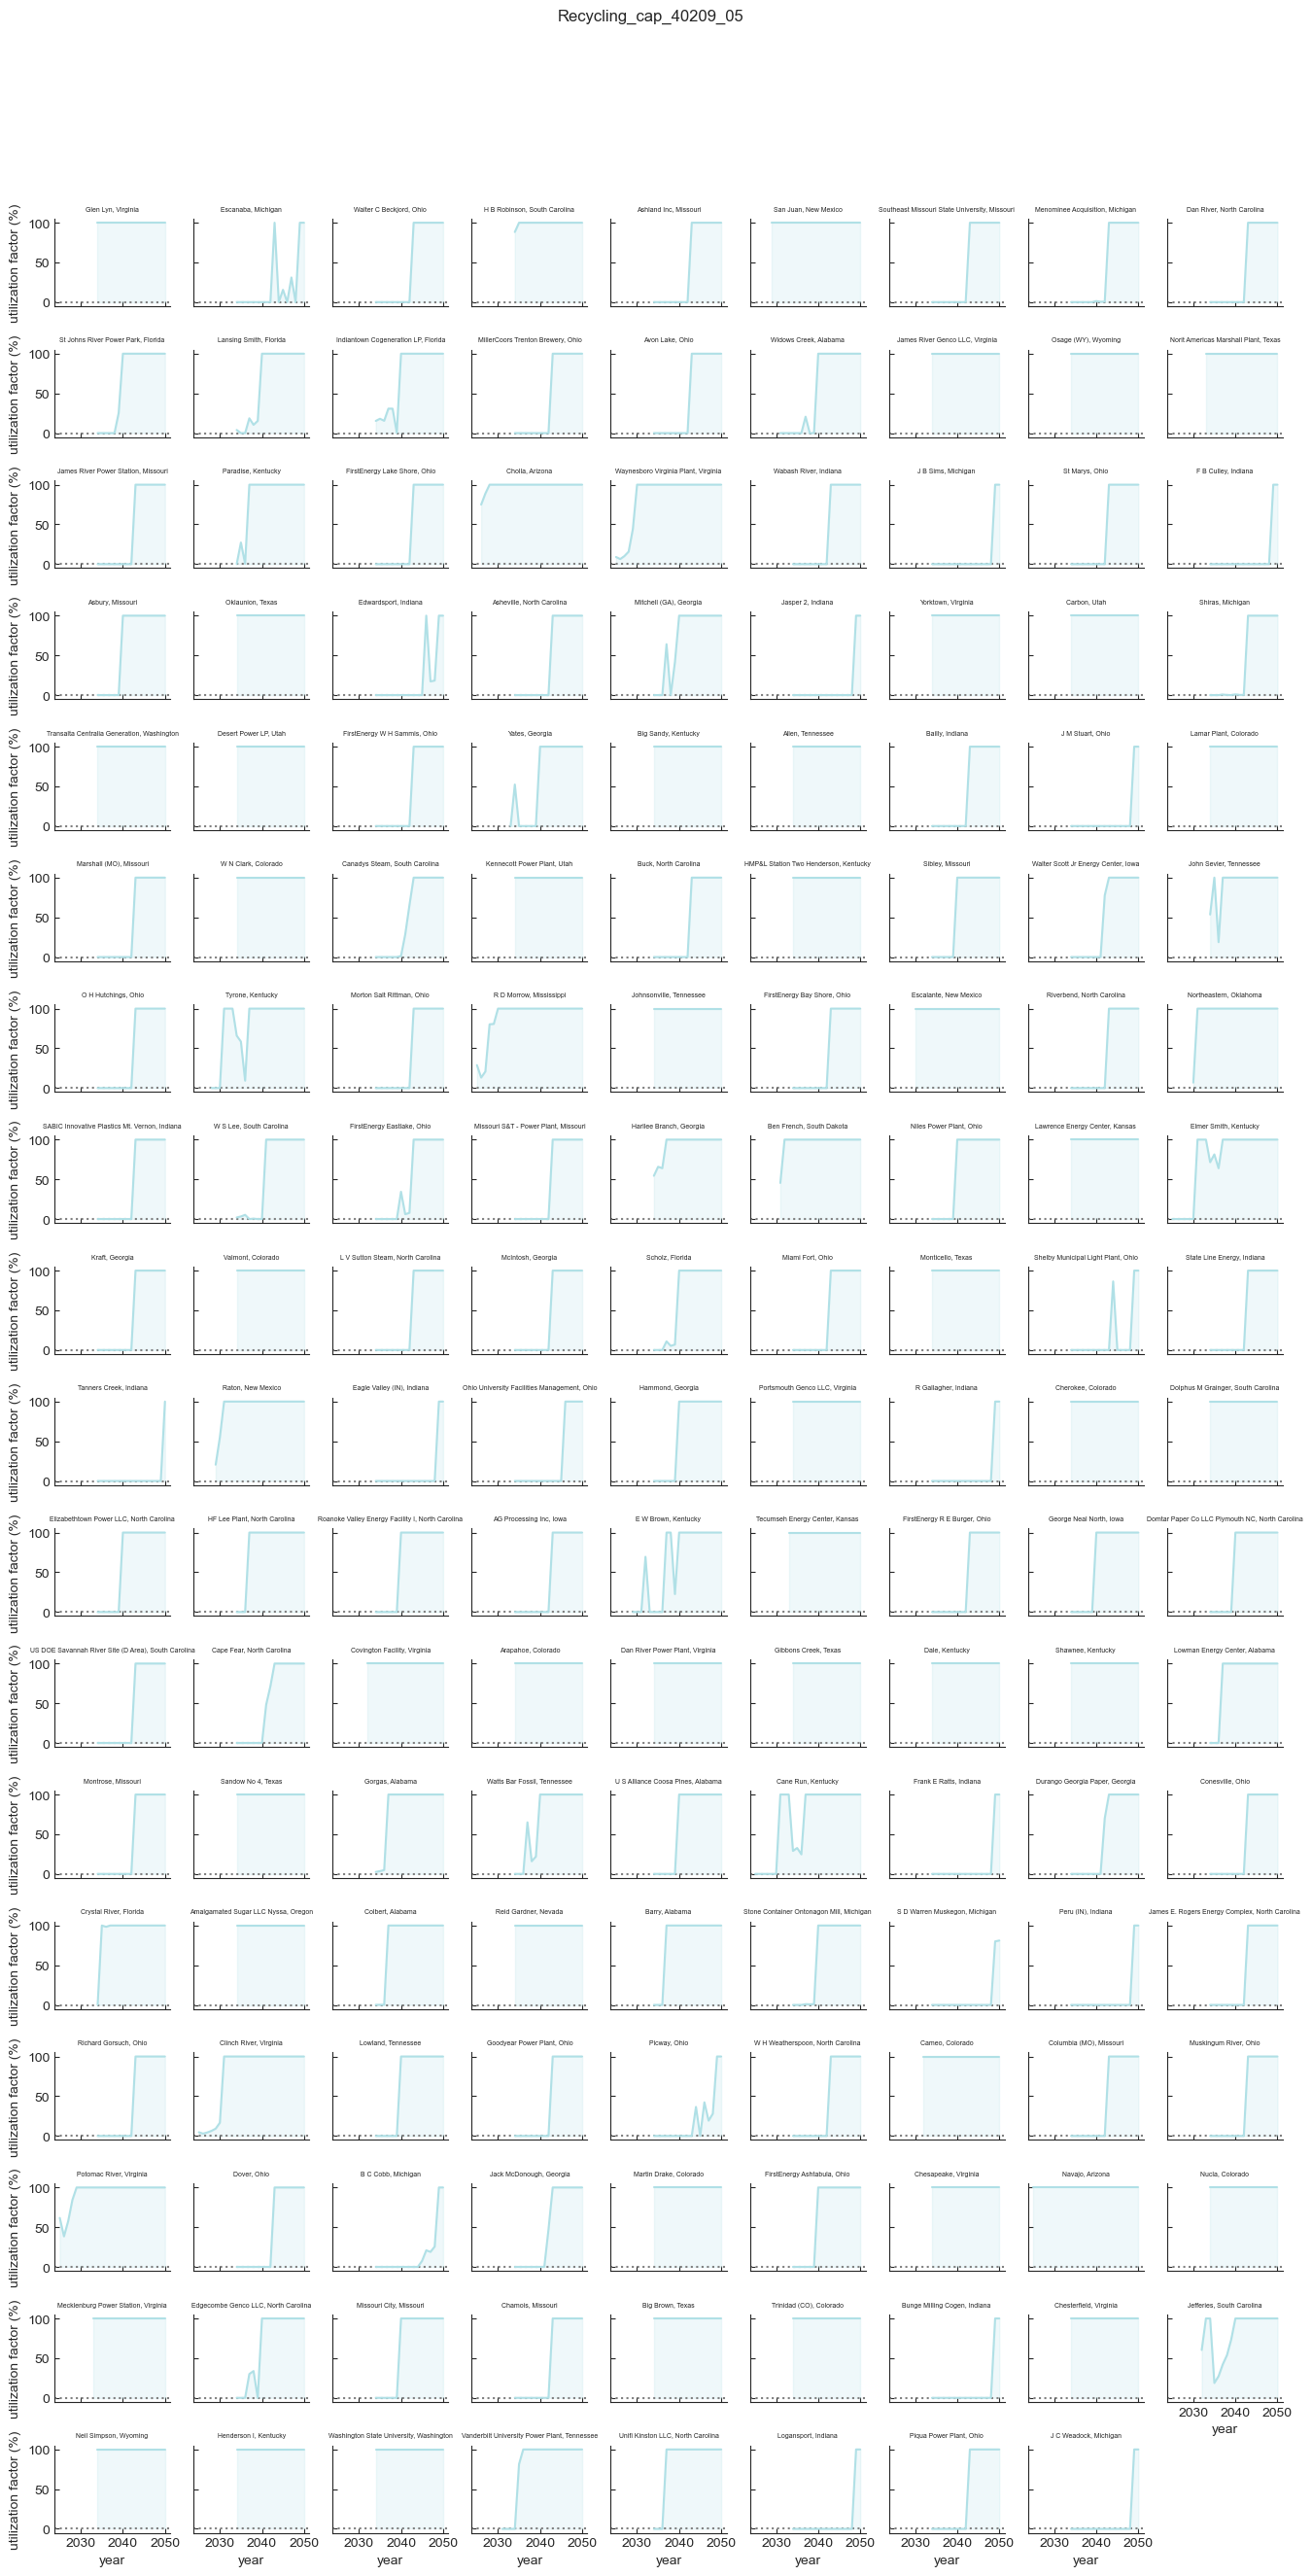

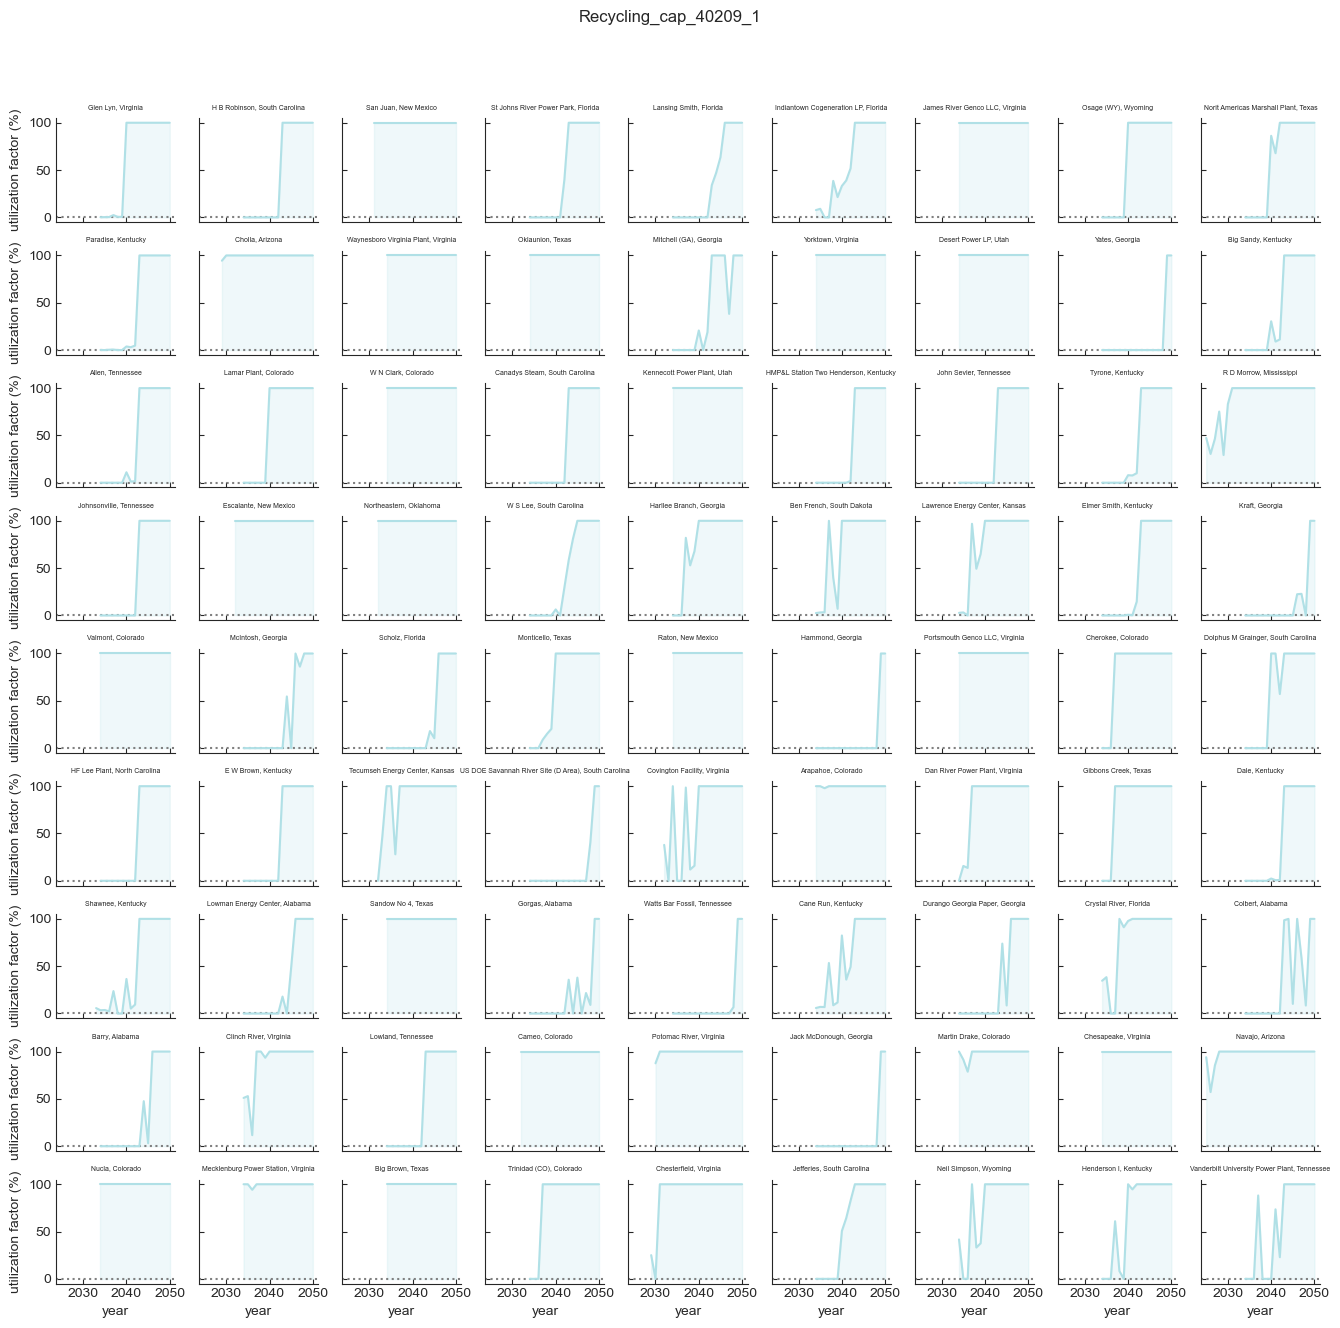

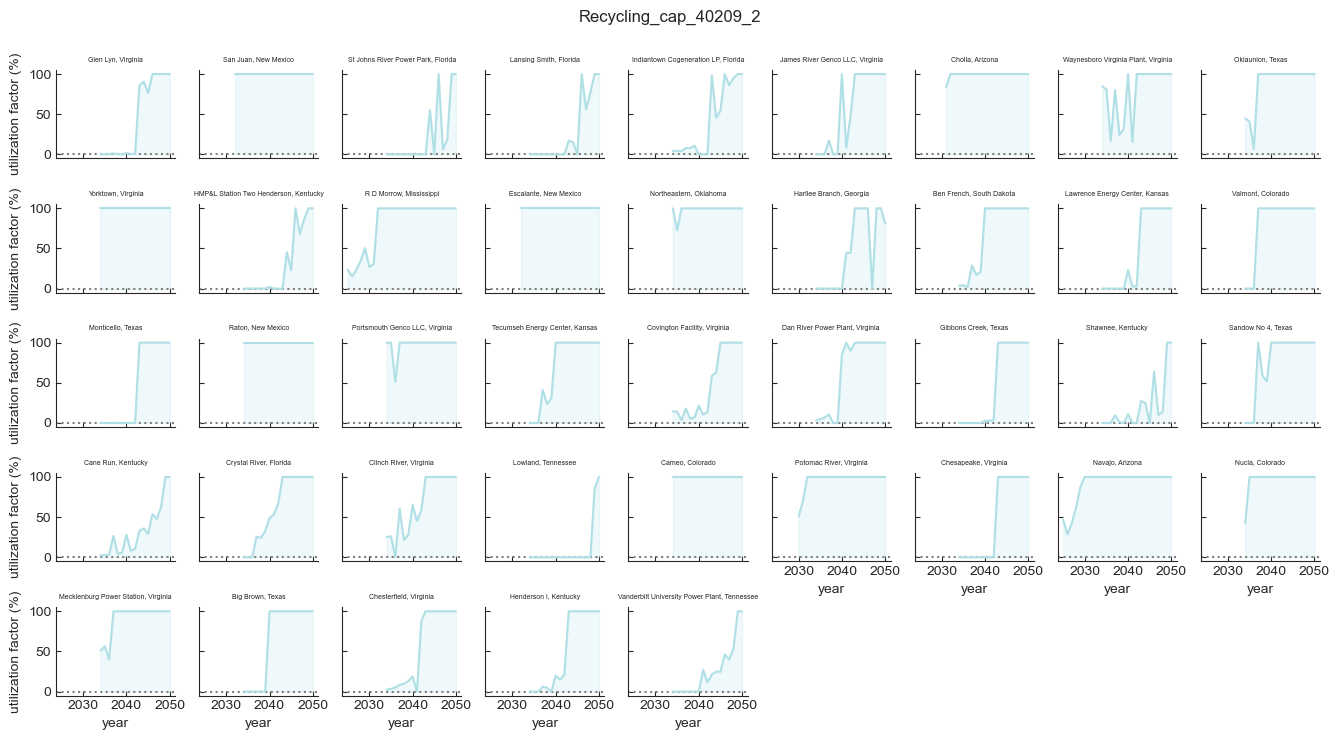

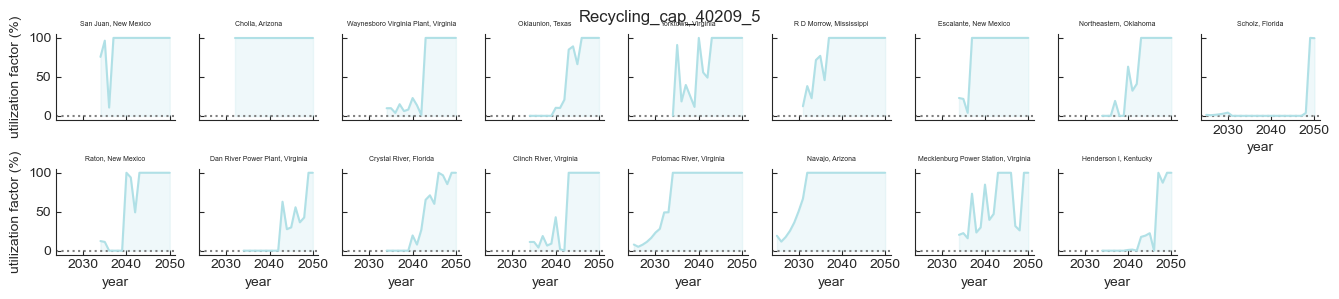

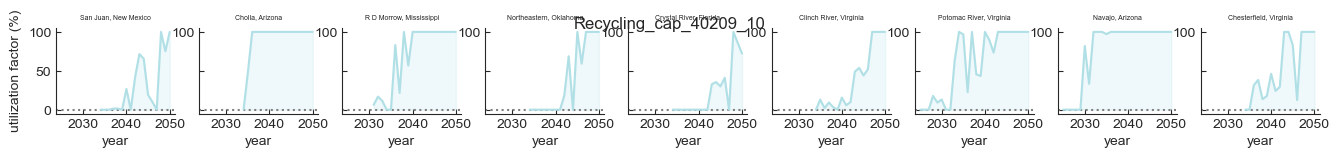

In [46]:
for files in recycling_files_cap:
# Initialize a grid of plots with an Axes for each walk
    grid = sns.FacetGrid(globals()['%s_plants' % (files)], col="location name",
                         col_wrap=9, height=1.5)

    # Draw a horizontal line to show the starting point
    grid.refline(y=0, linestyle=":")


    grid.map(plt.plot, "year", "utilization factor (%)", color="powderblue")
    grid.map(plt.fill_between, 'year', 'utilization factor (%)',color= "powderblue", alpha= 0.2)
    # Adjust the tick positions, labels and 
    #sns.set(font_scale=0.1)
    grid.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=5)

    grid.fig.tight_layout(w_pad=1)
    grid.fig.subplots_adjust(top=0.9)
    grid.fig.suptitle(f"{files}")


    plt.savefig(os.path.join(cwd, f"grid_after_update/grid_{files}_cap_uf.png"), transparent=True);


#### Recycling Capacity Total Cost

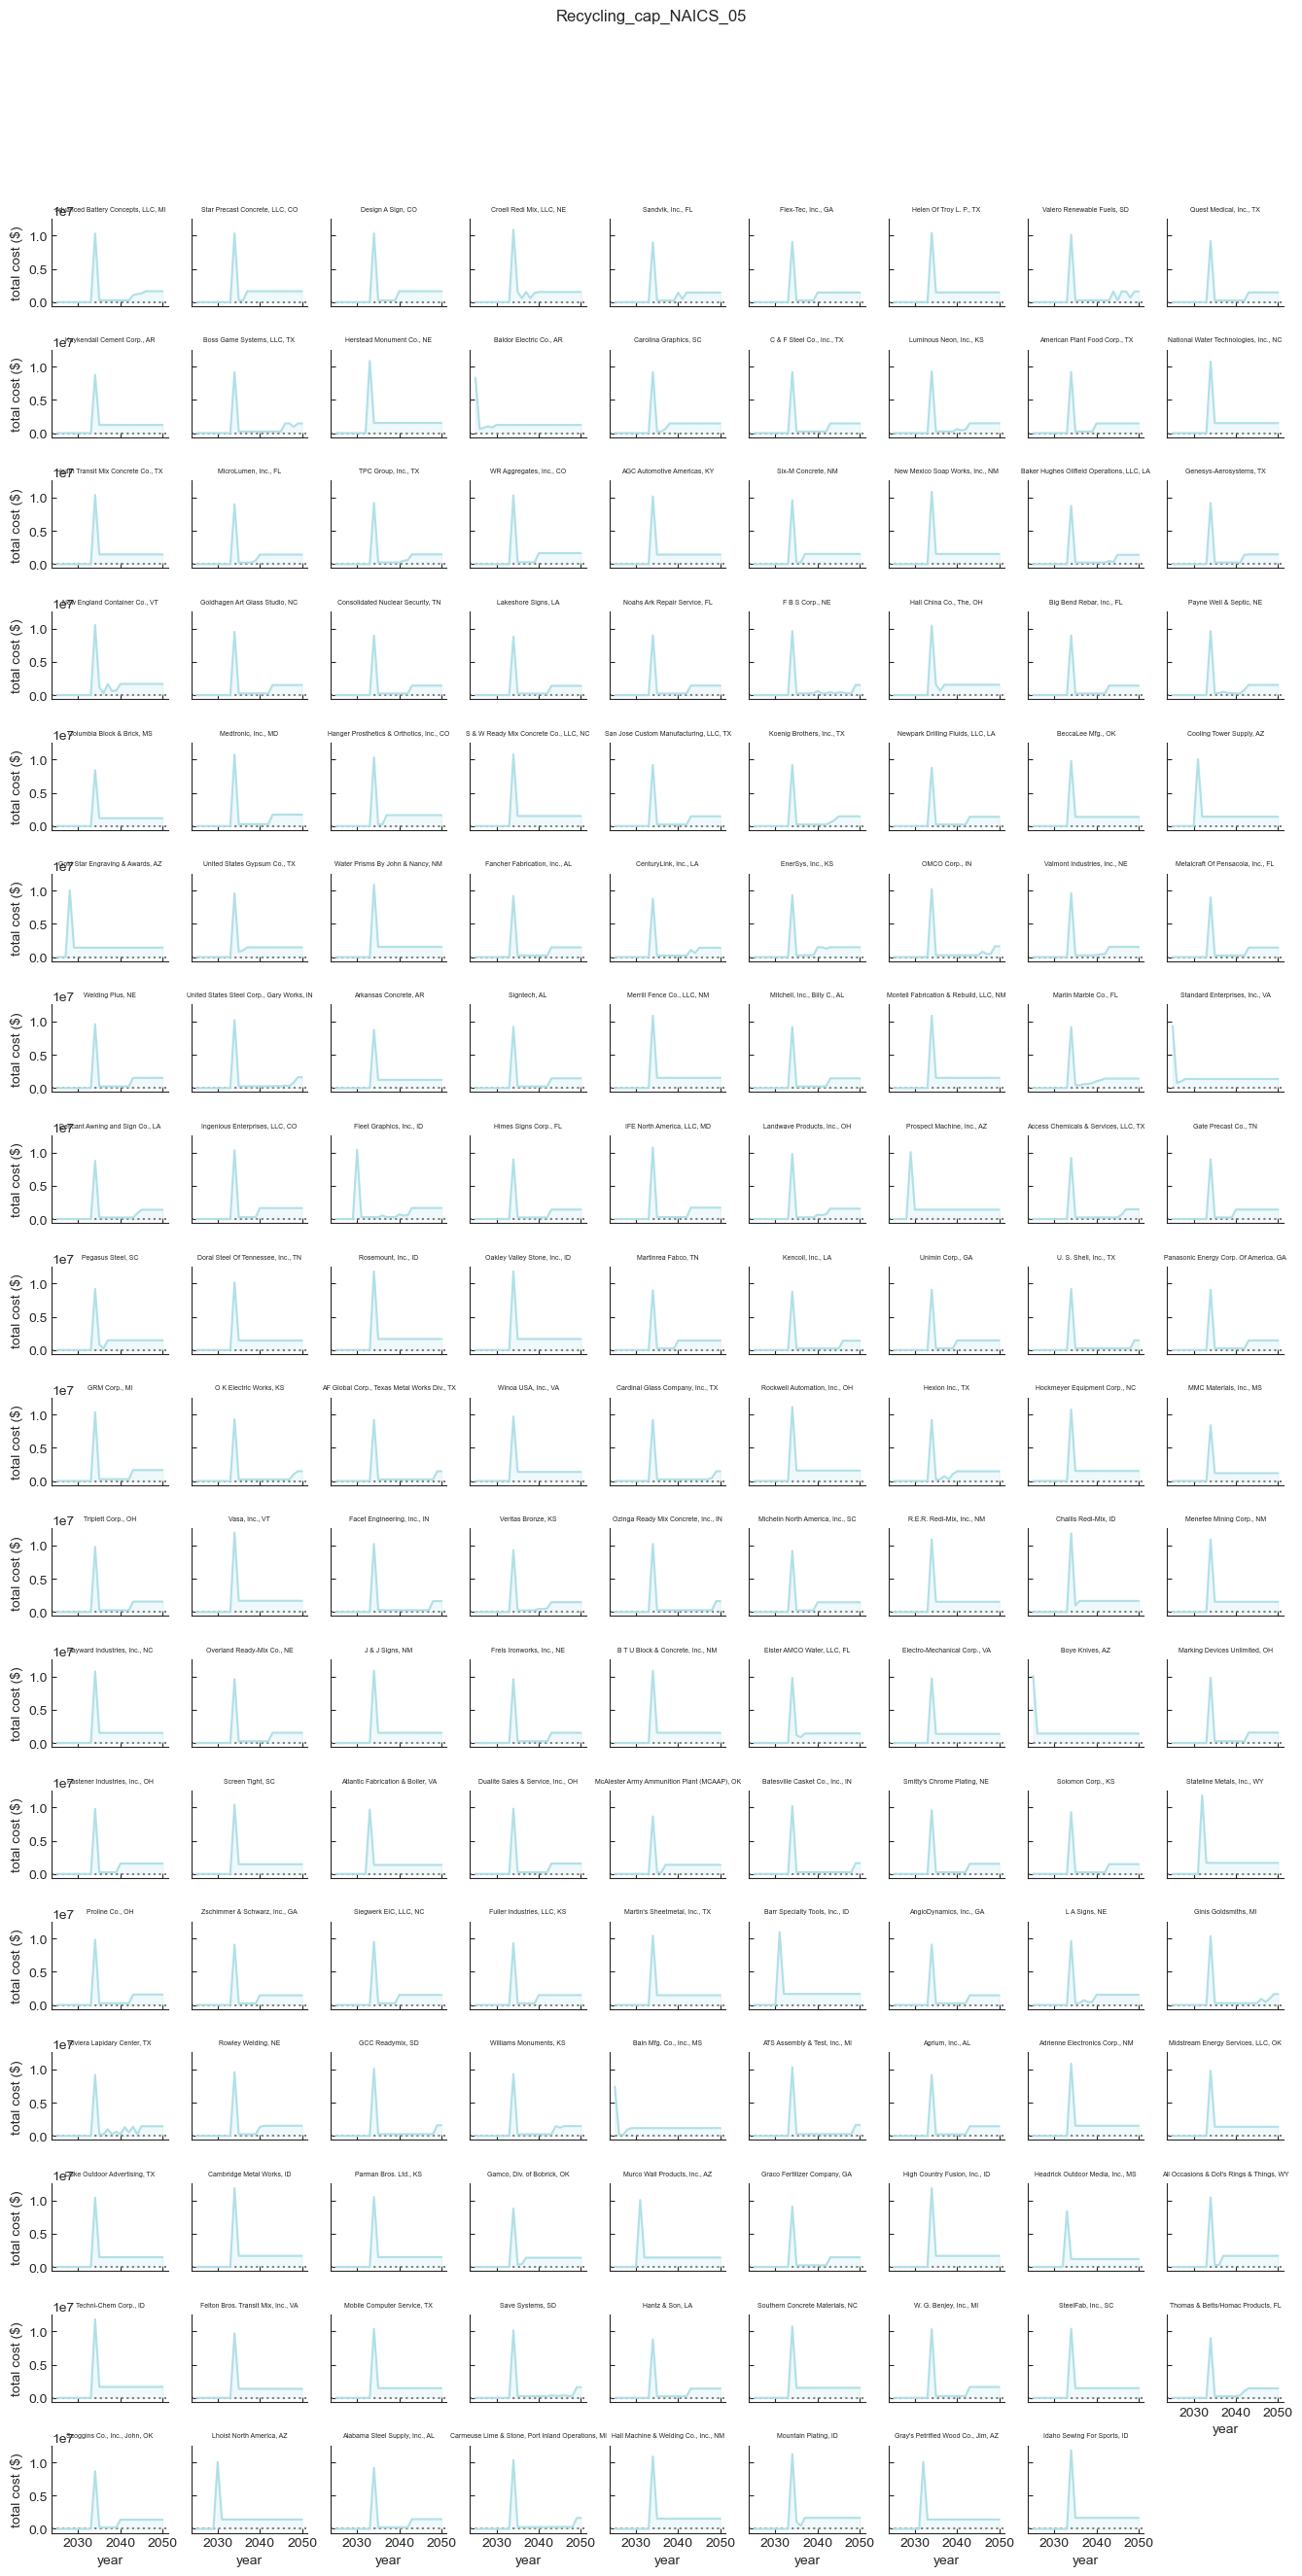

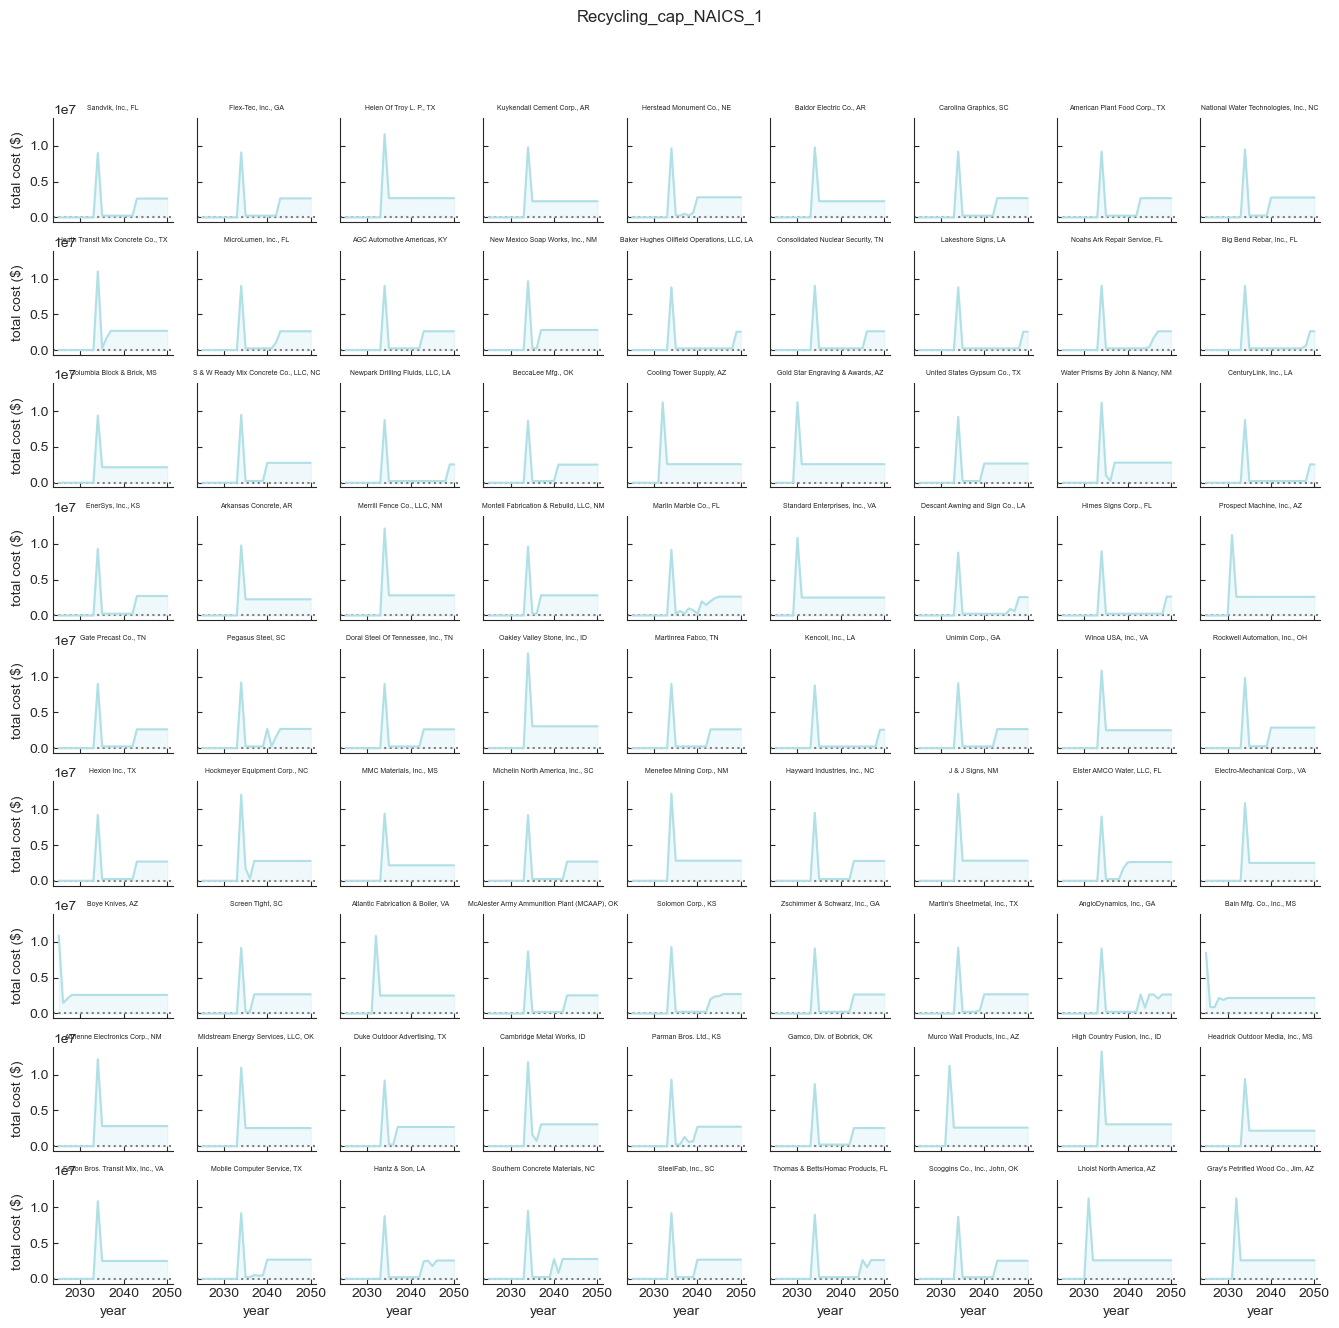

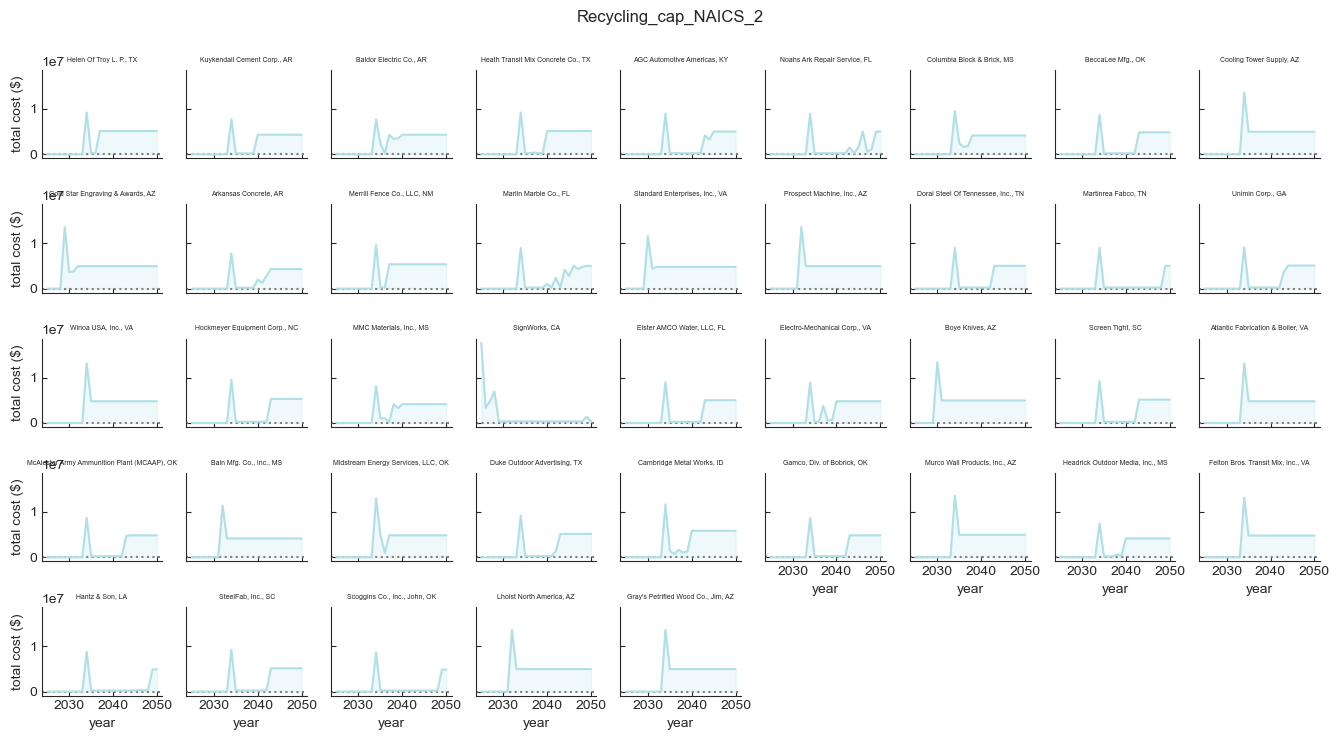

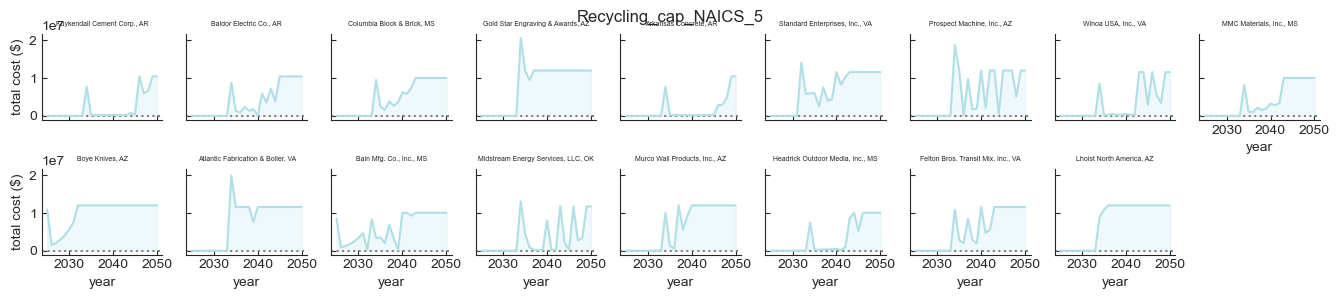

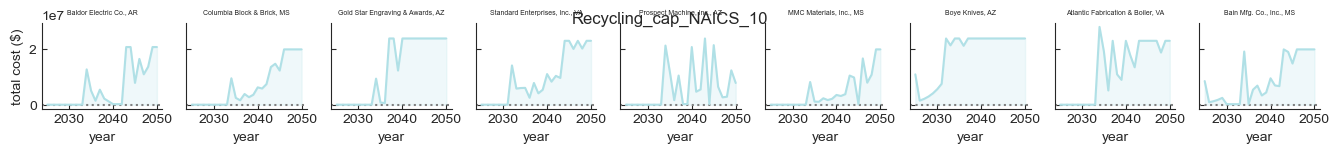

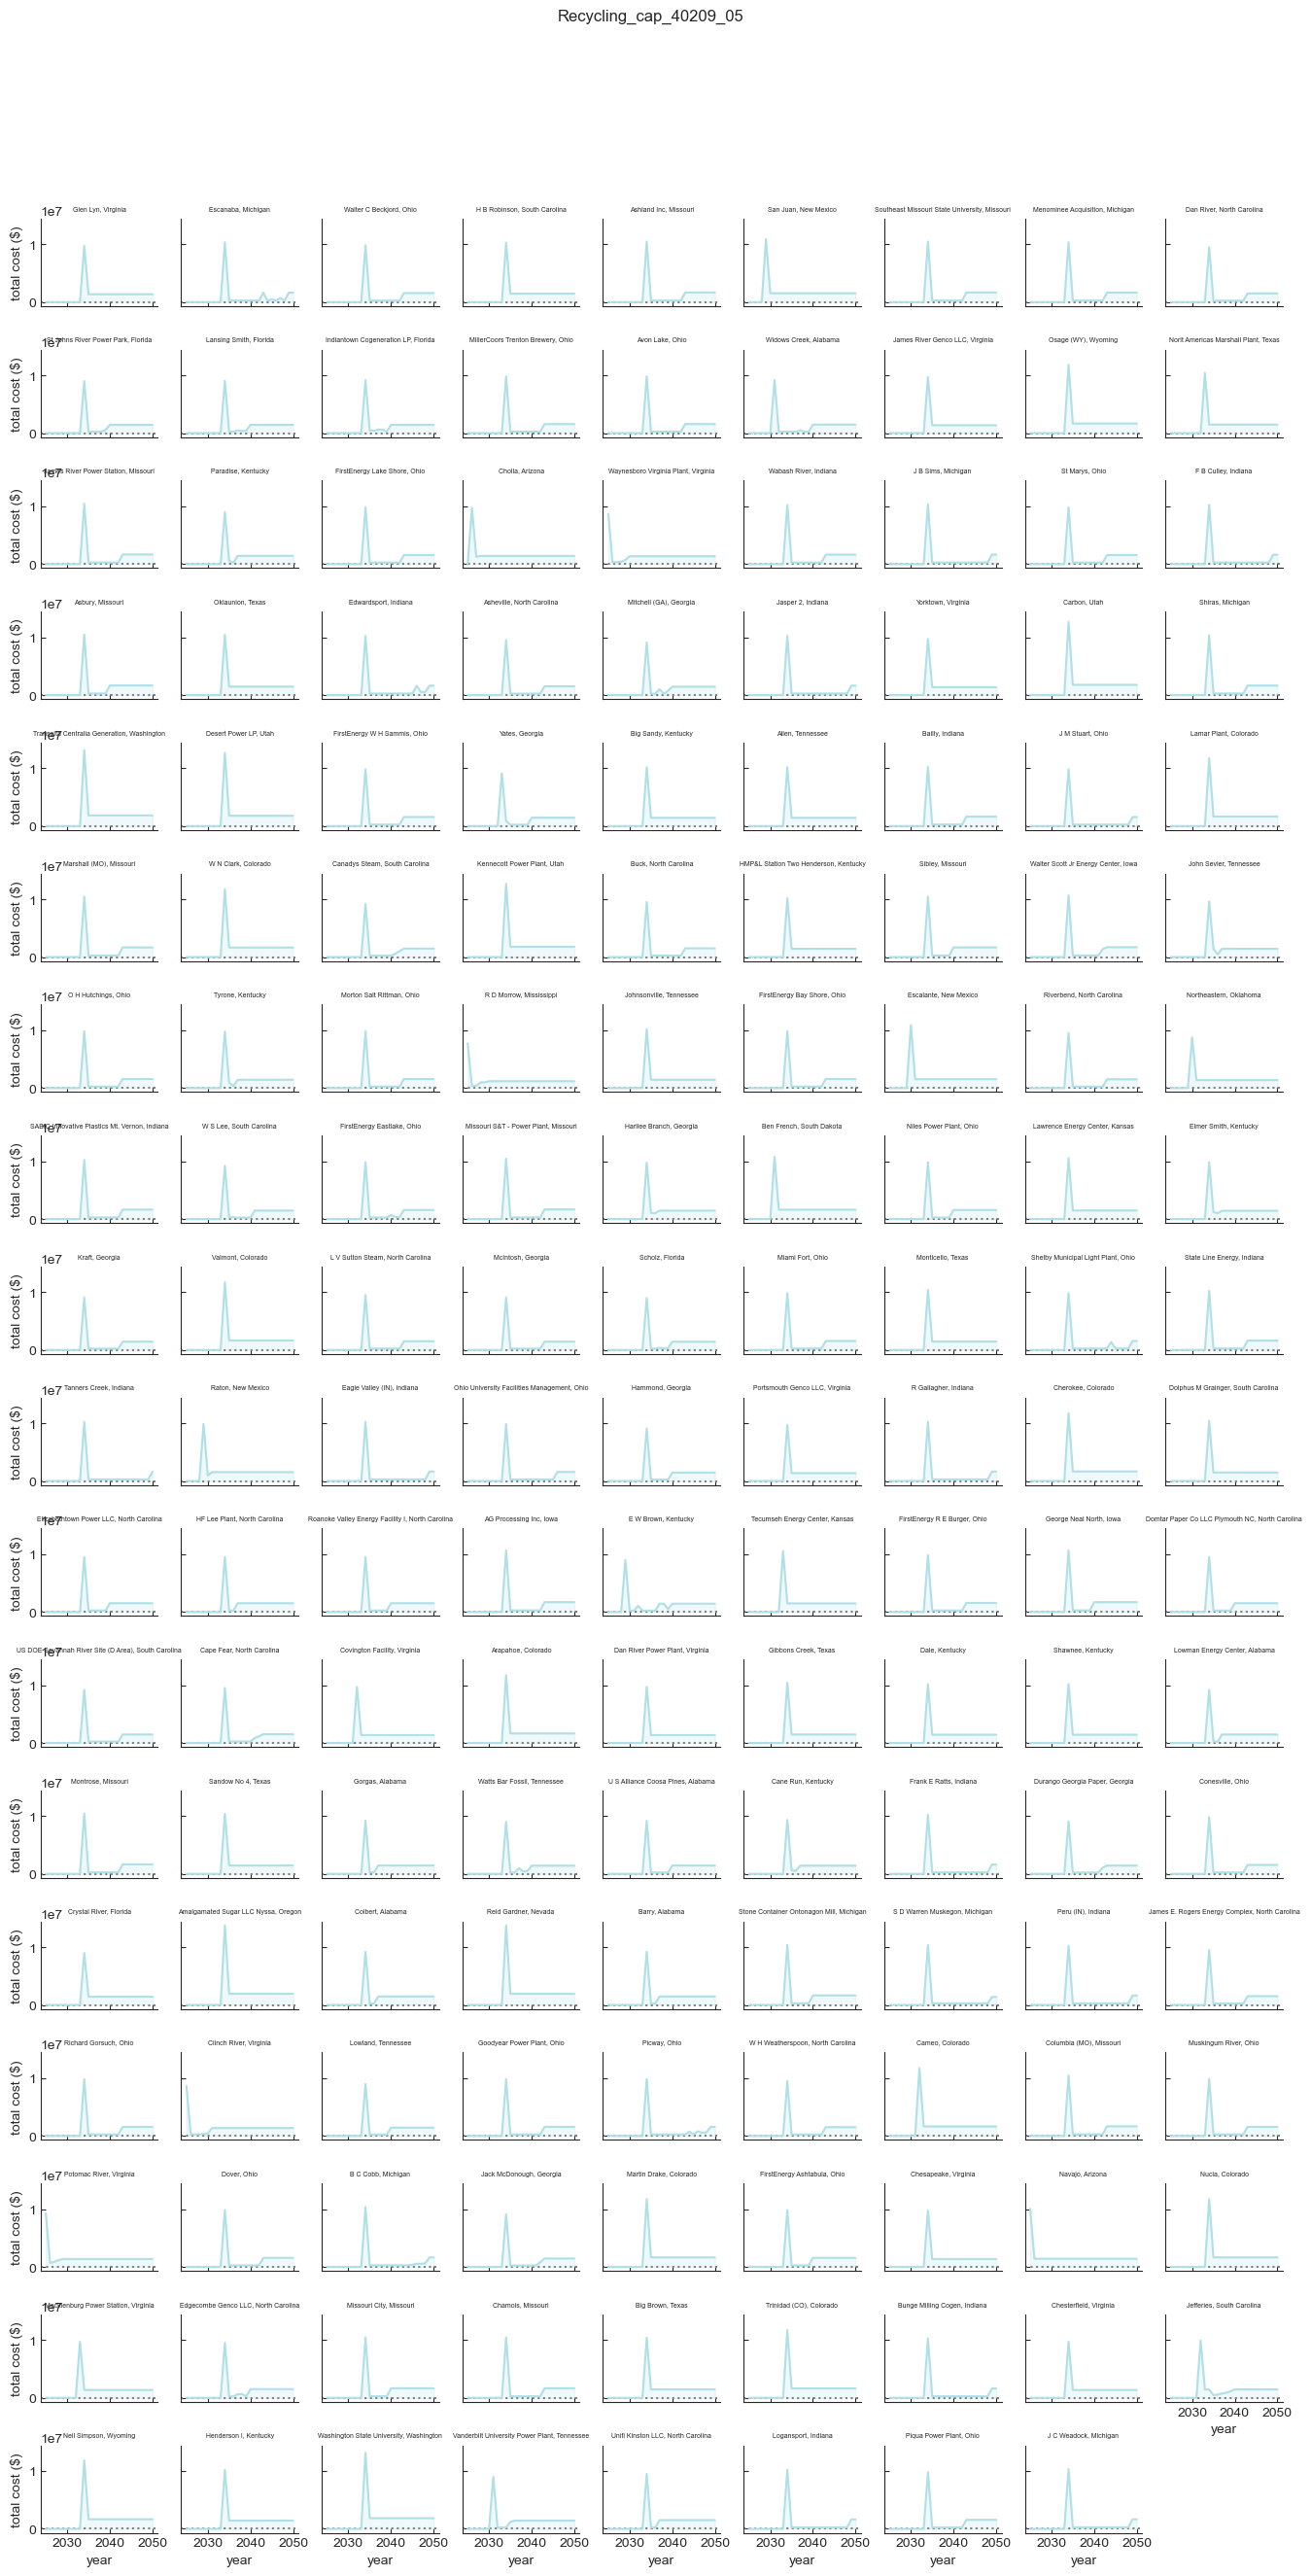

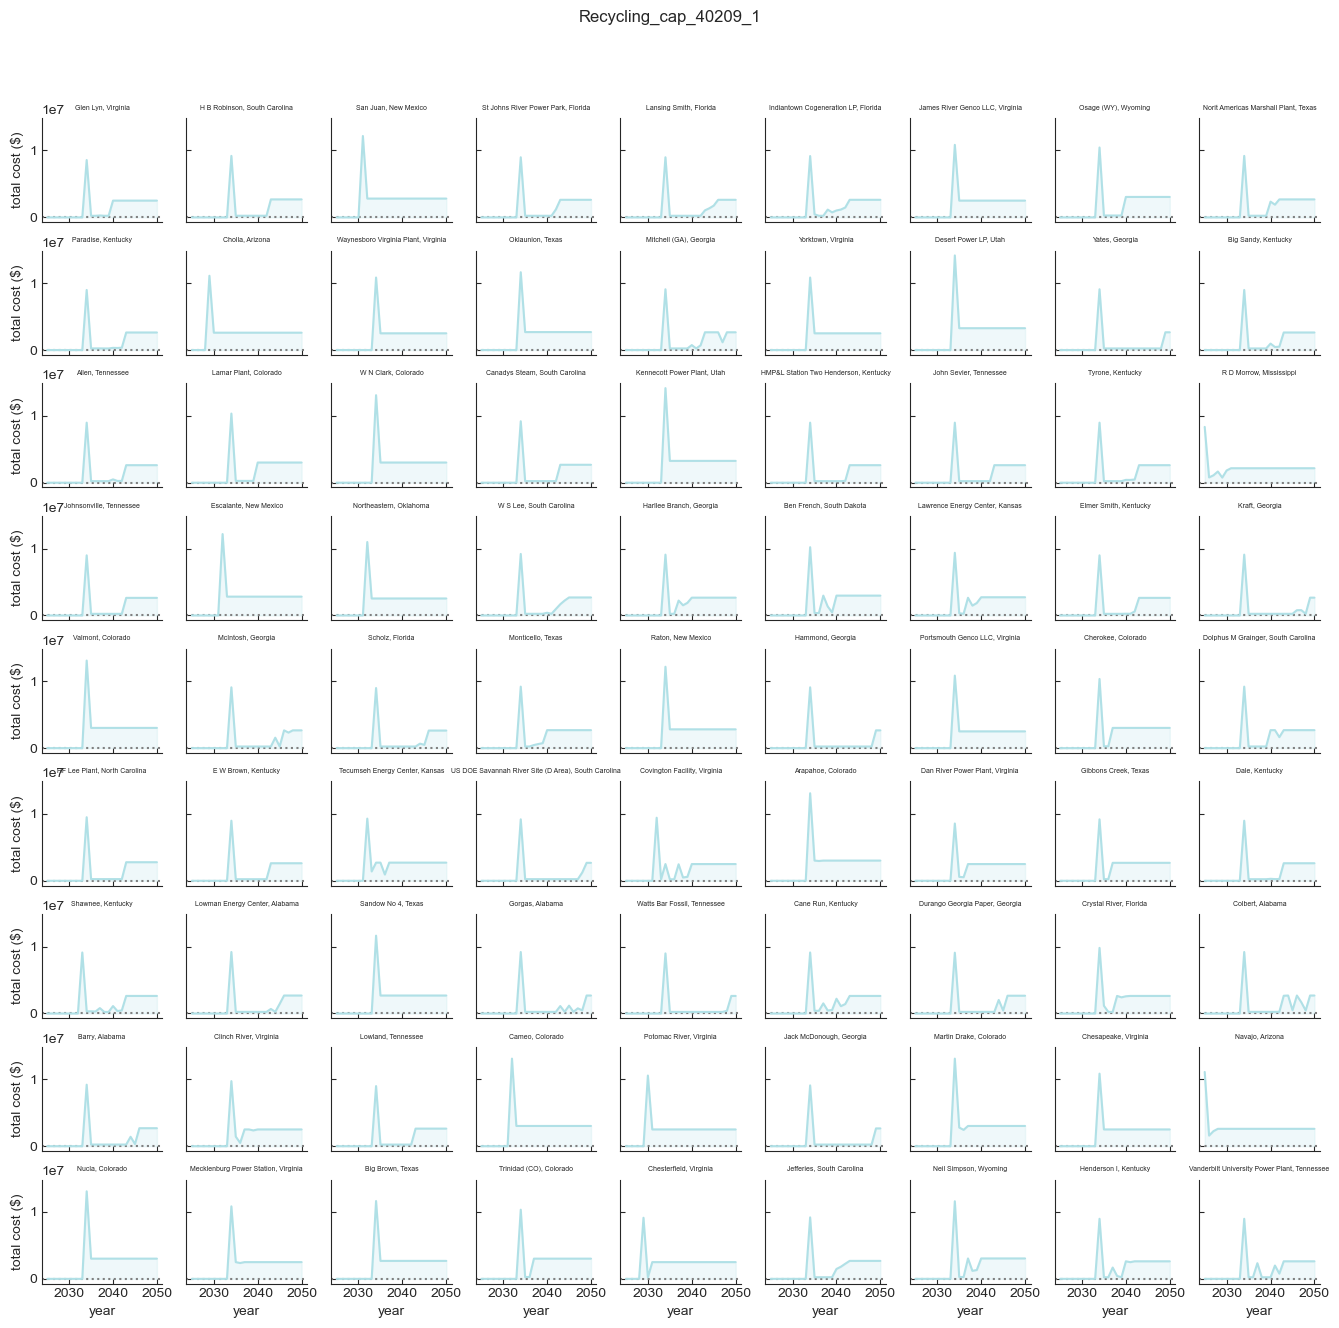

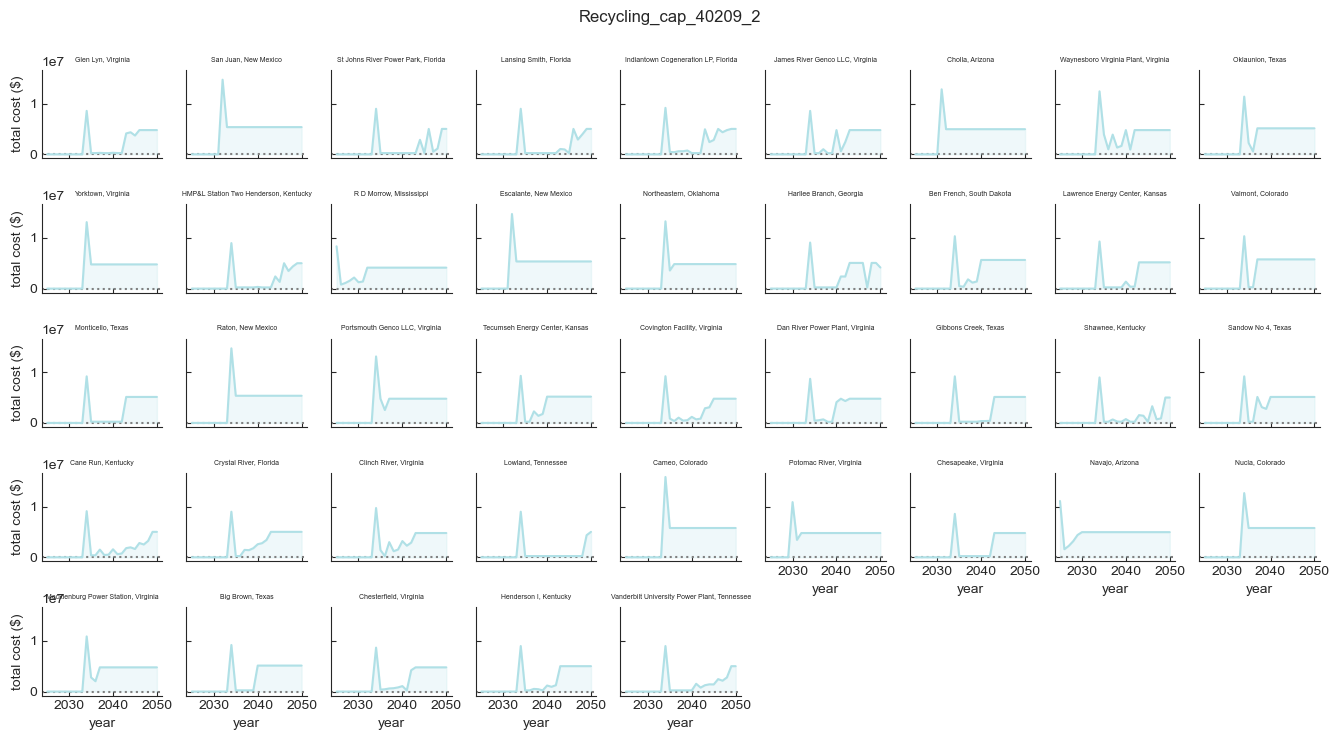

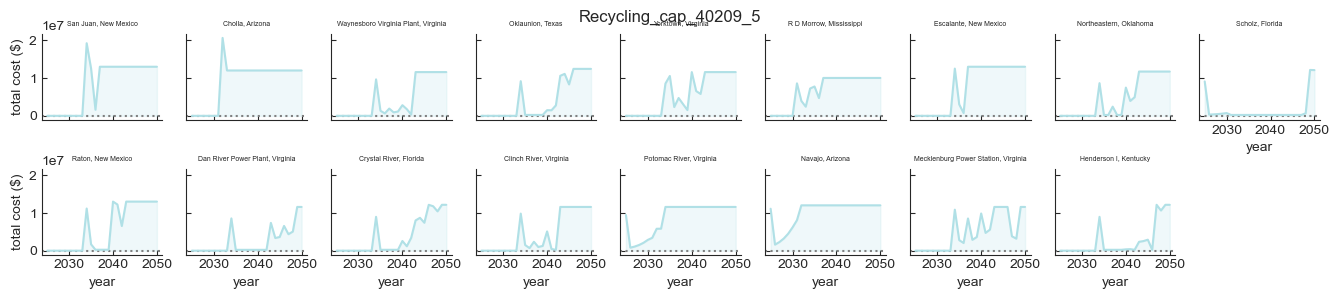

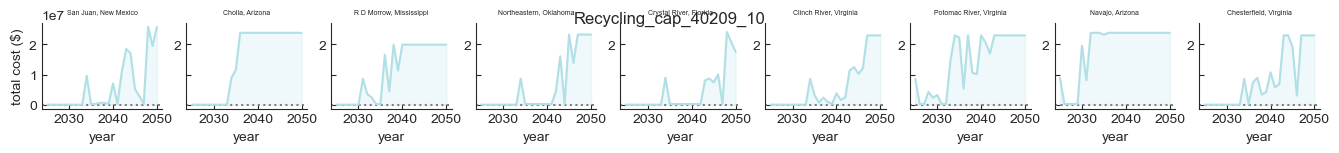

In [ ]:
for files in recycling_files_cap:
# Initialize a grid of plots with an Axes for each walk
    grid = sns.FacetGrid(globals()['%s_plants' % (files)], col="location name",
                         col_wrap=9, height=1.5)

    # Draw a horizontal line to show the starting point
    grid.refline(y=0, linestyle=":")


    grid.map(plt.plot, "year", "total cost ($)", color="powderblue")
    grid.map(plt.fill_between, 'year', 'total cost ($)',color= "powderblue", alpha= 0.2)
    # Adjust the tick positions, labels and 
    #sns.set(font_scale=0.1)
    grid.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=5)

    grid.fig.tight_layout(w_pad=1)
    grid.fig.subplots_adjust(top=0.9)
    grid.fig.suptitle(f"{files}")


    plt.savefig(os.path.join(cwd, f"grid_after_update/grid_{files}_cap_totcost.png"), transparent=True);


#### Recycling Cost Utilization Factor

In [ ]:
for files in recycling_files_cost:
# Initialize a grid of plots with an Axes for each walk
# Initialize a grid of plots with an Axes for each walk
    grid = sns.FacetGrid(globals()['%s_plants' % (files)], col="location name",
                         col_wrap=9, height=1.5)

    # Draw a horizontal line to show the starting point
    grid.refline(y=0, linestyle=":")


    grid.map(plt.plot, "year", "utilization factor (%)", color="powderblue")
    grid.map(plt.fill_between, "year", 'utilization factor (%)',color= "powderblue", alpha= 0.2)
    # Adjust the tick positions, labels and 
    #sns.set(font_scale=0.1)
    grid.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=5)

    grid.fig.tight_layout(w_pad=1)
    grid.fig.subplots_adjust(top=0.9)
    grid.fig.suptitle(f"{files}")


    plt.savefig(os.path.join(cwd, f"grid_after_update/grid_{files}_cost_uf.png"), transparent=True);


#### Recycling Cost Total Cost

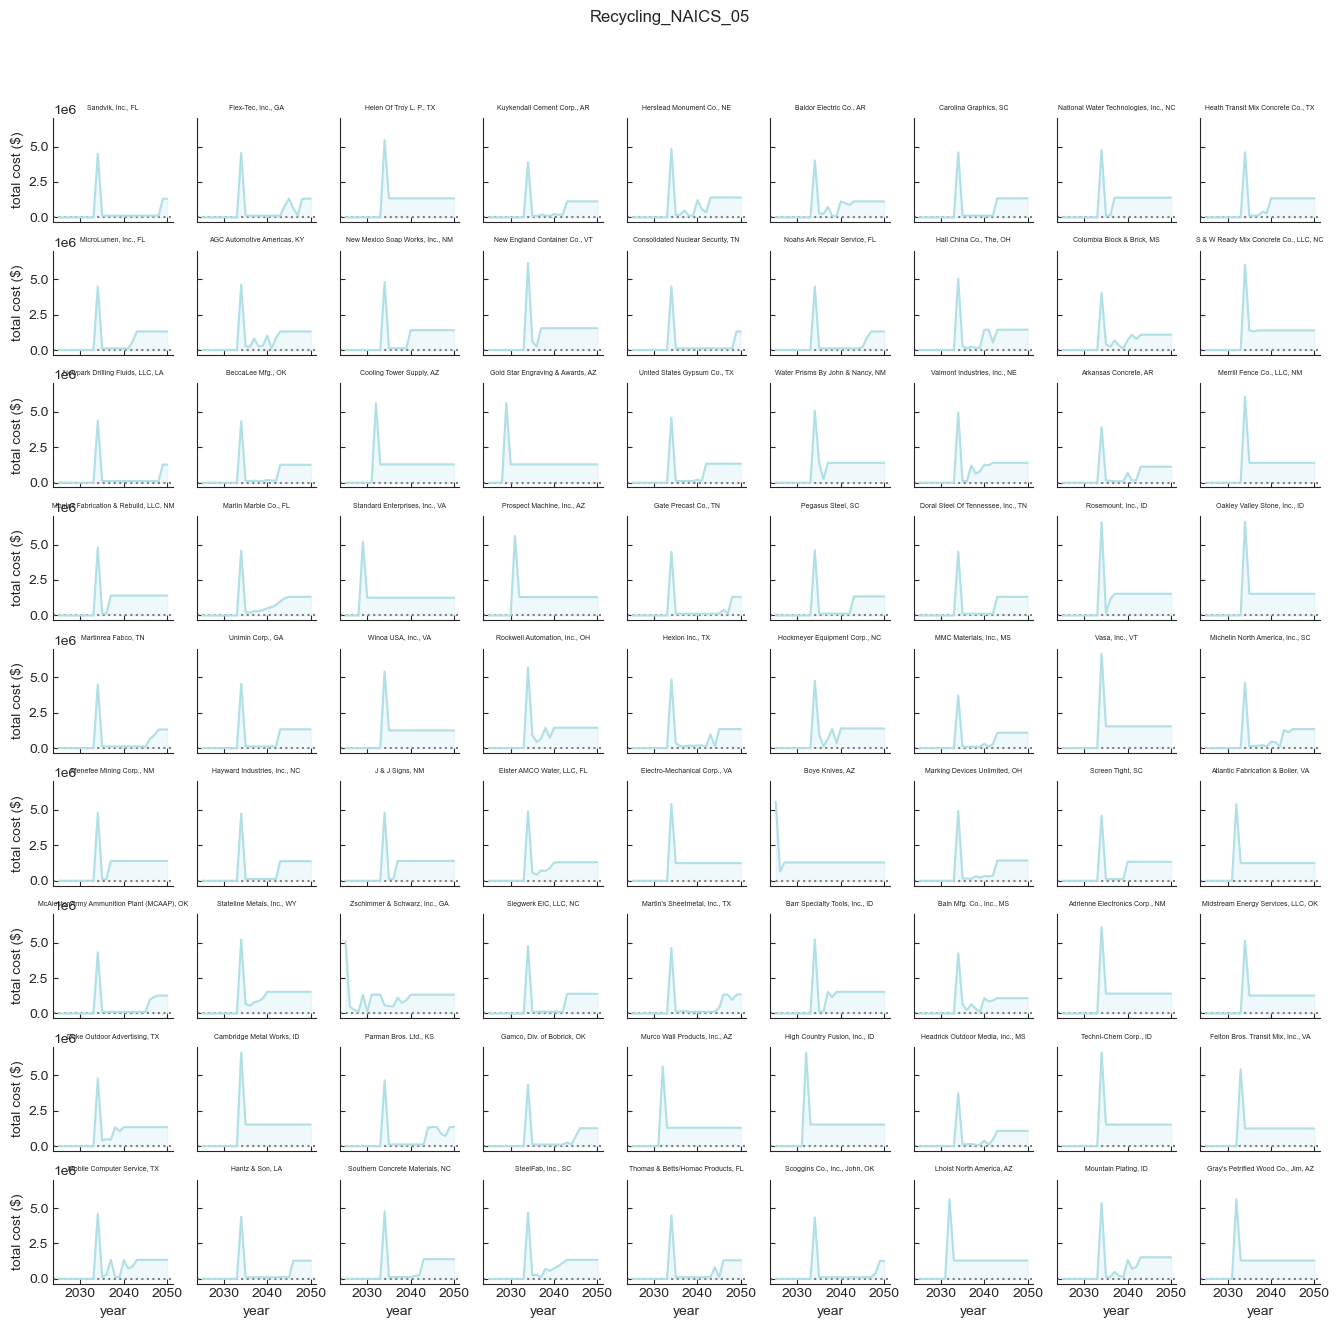

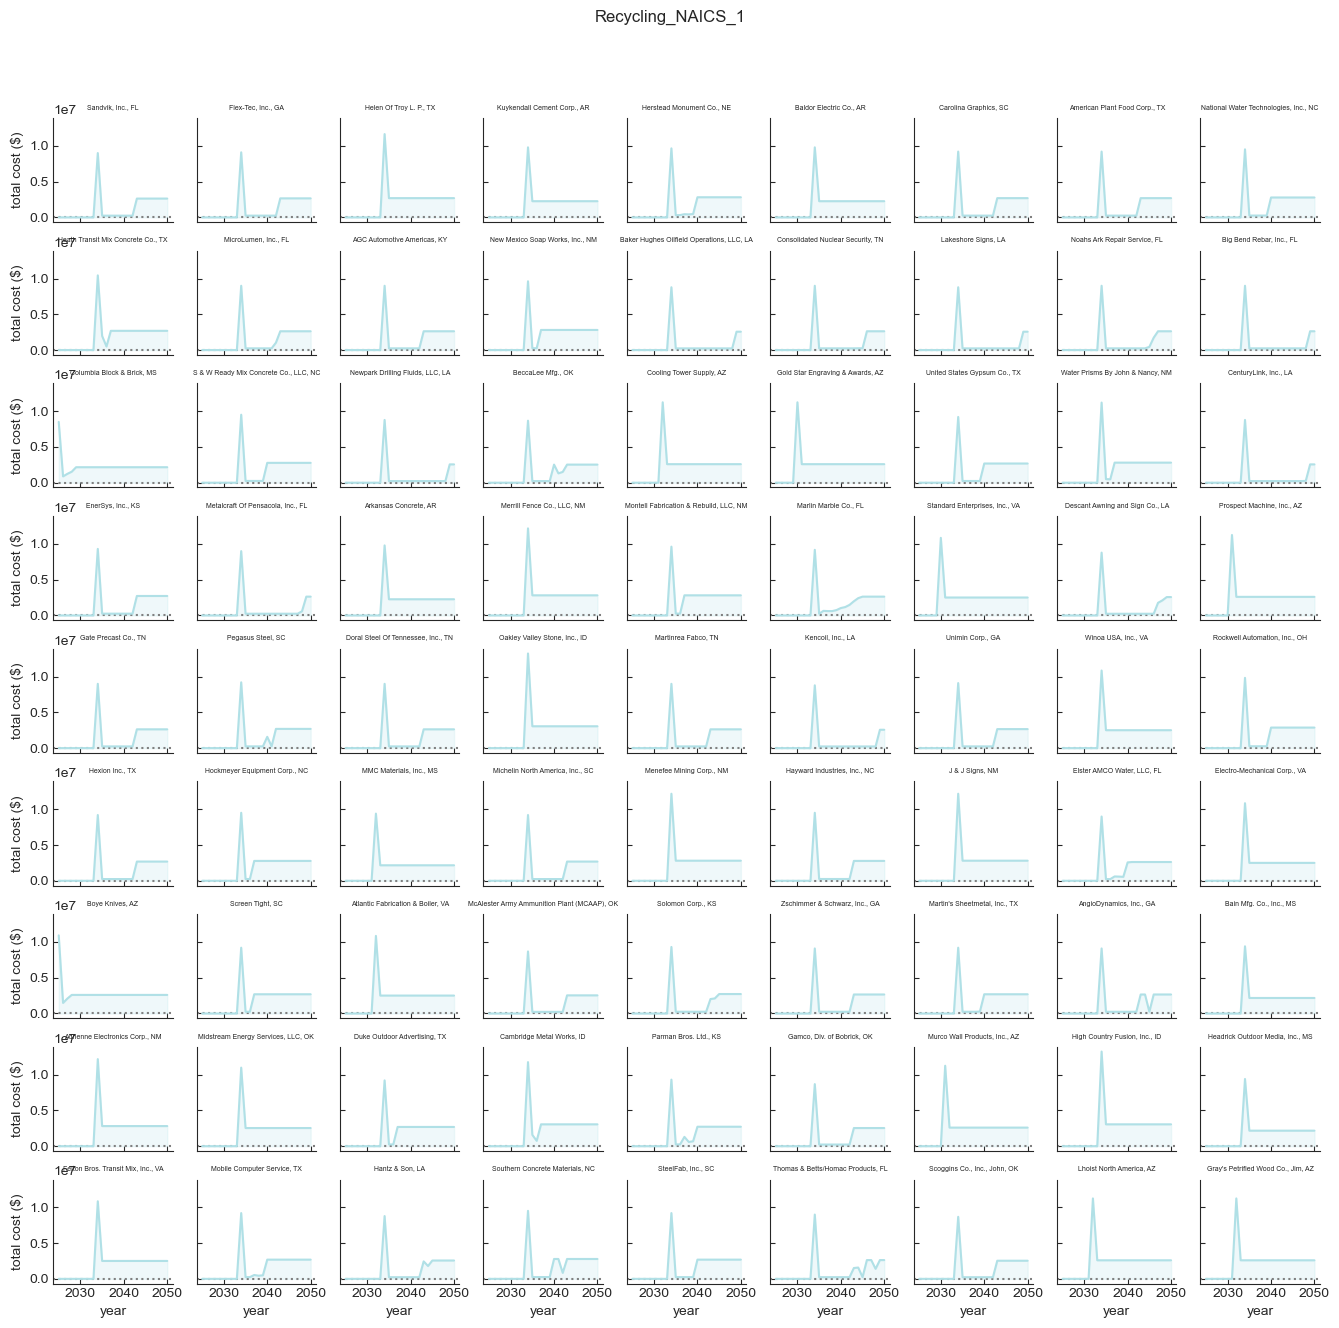

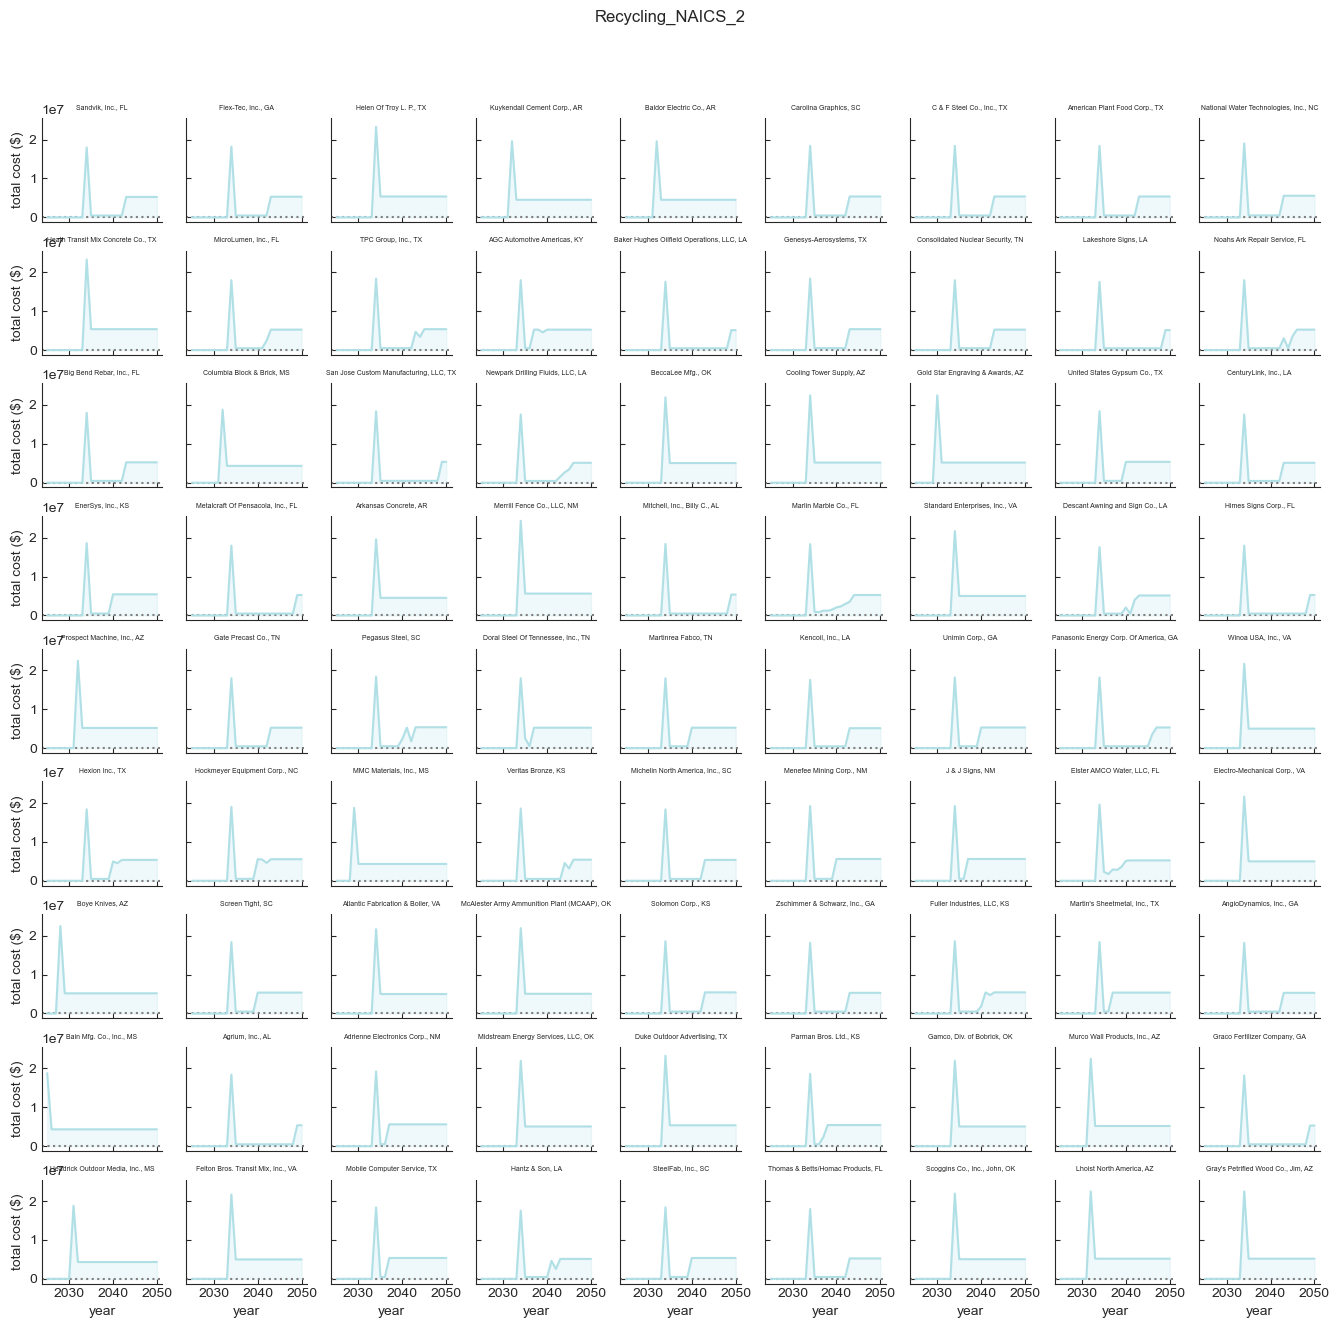

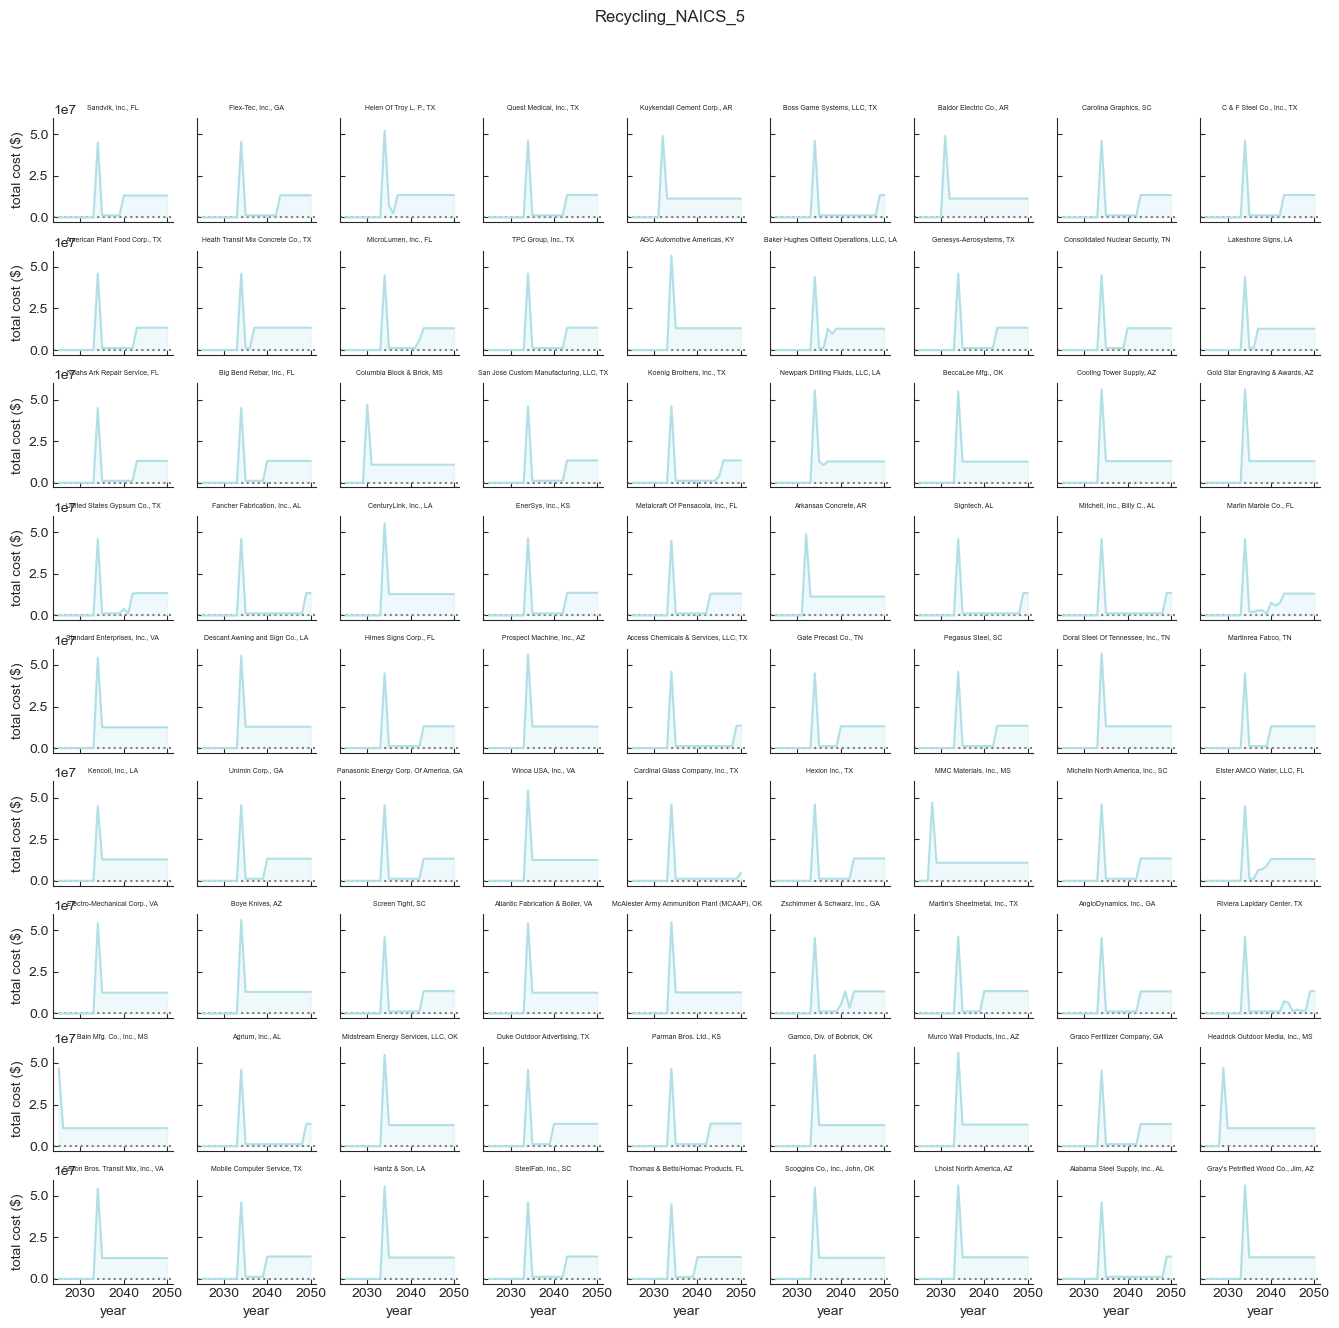

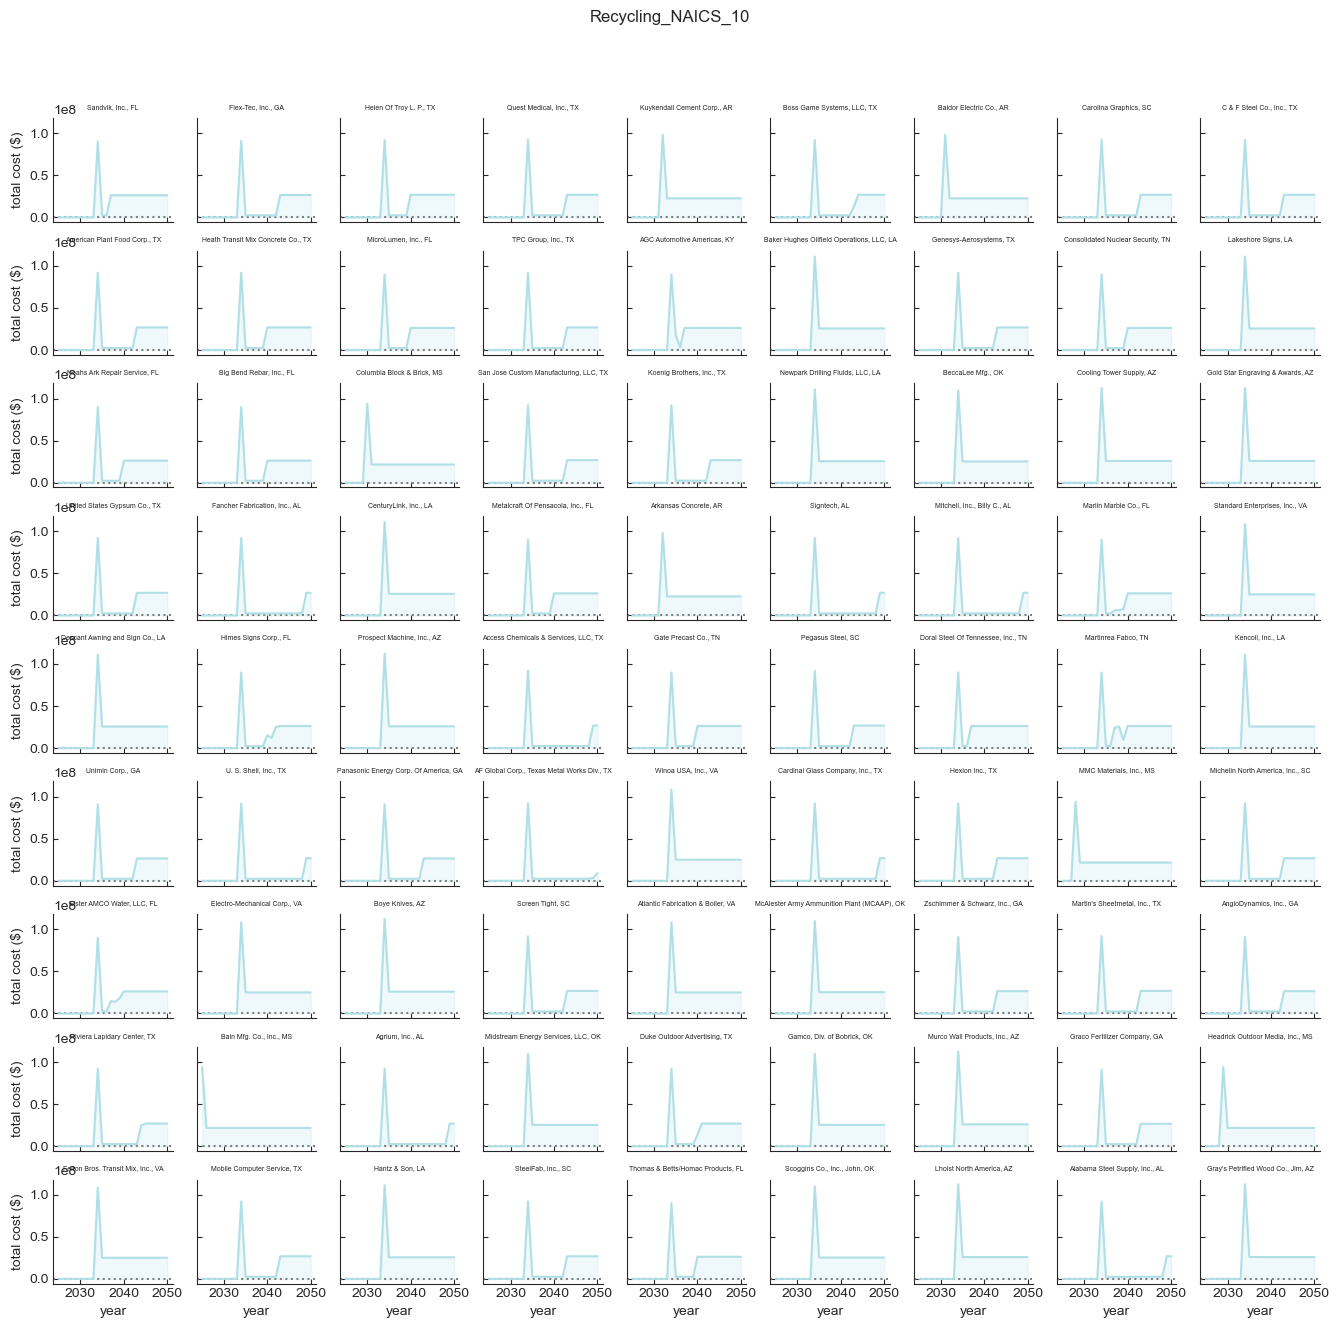

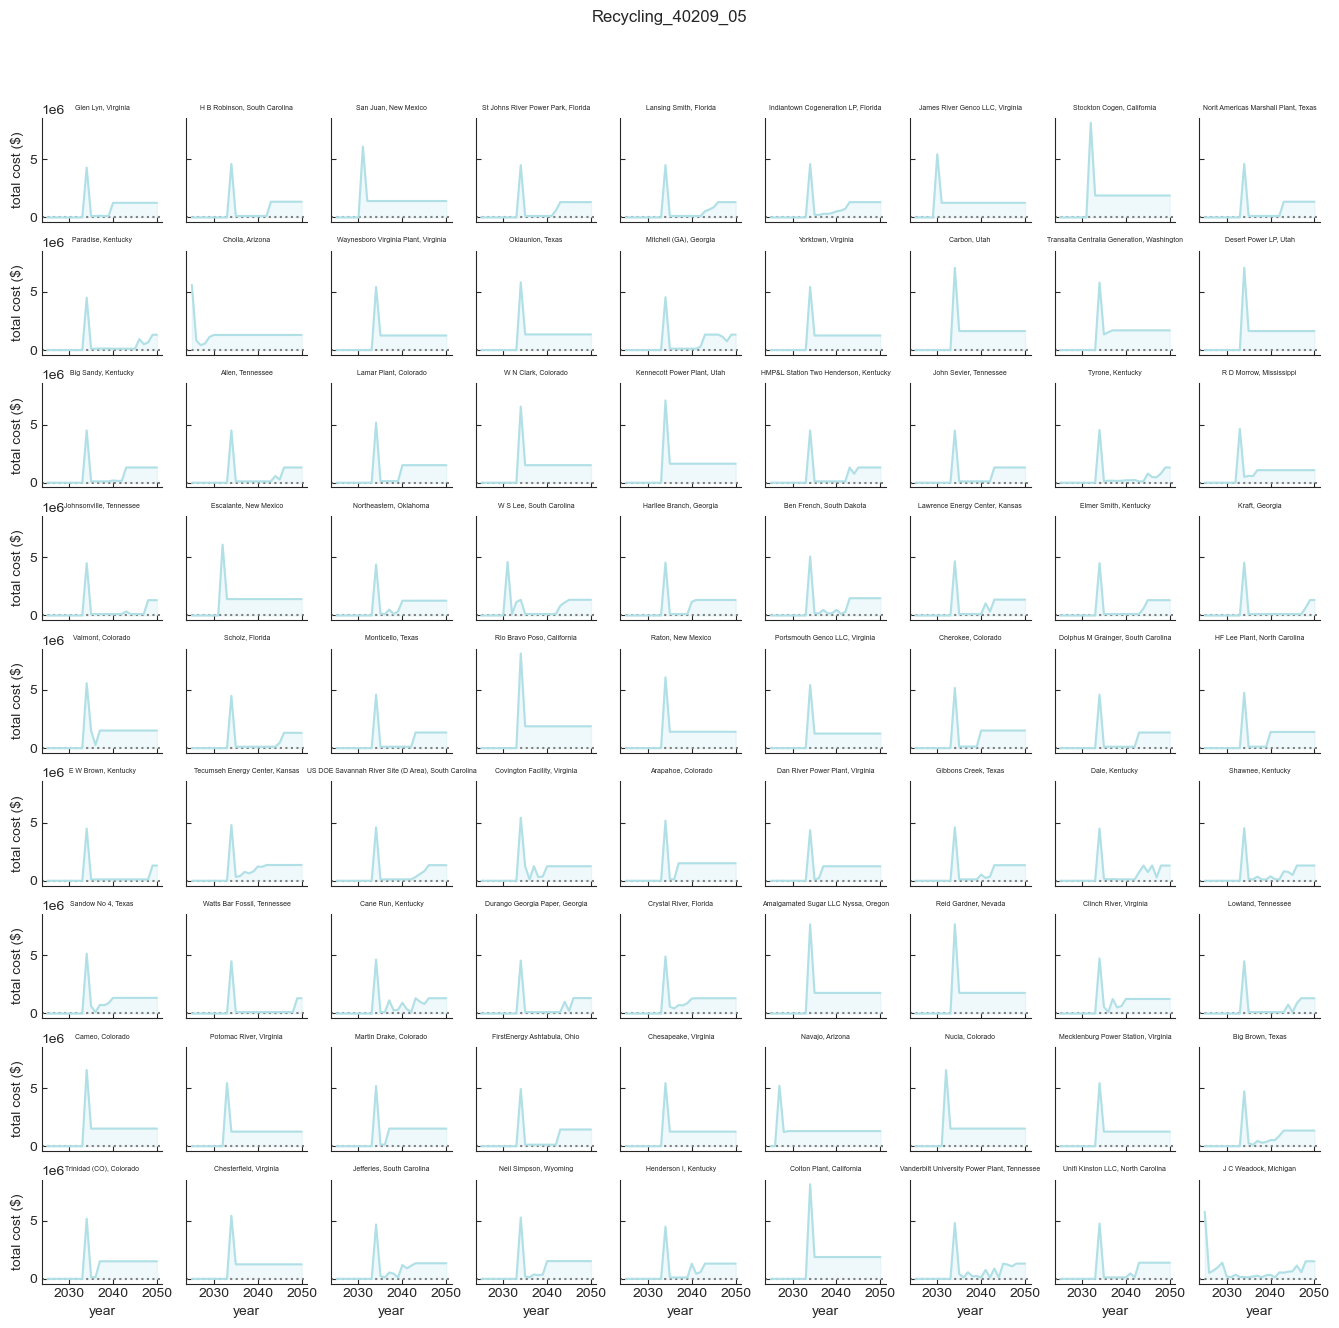

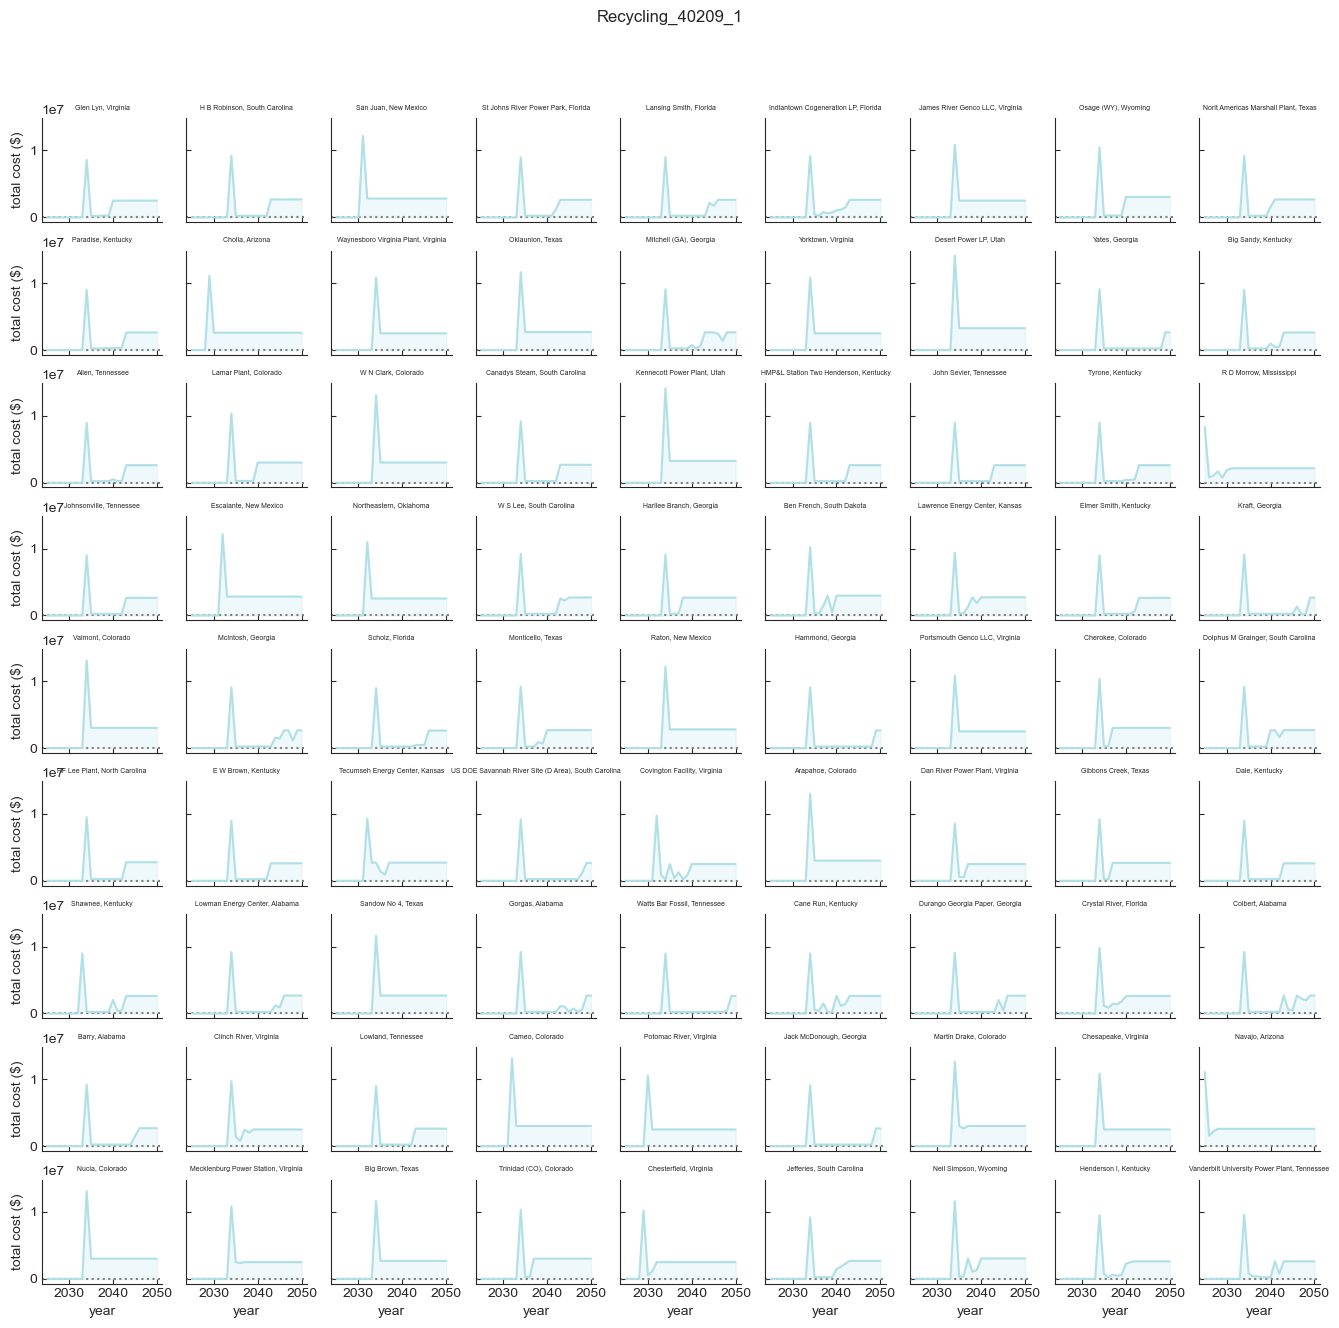

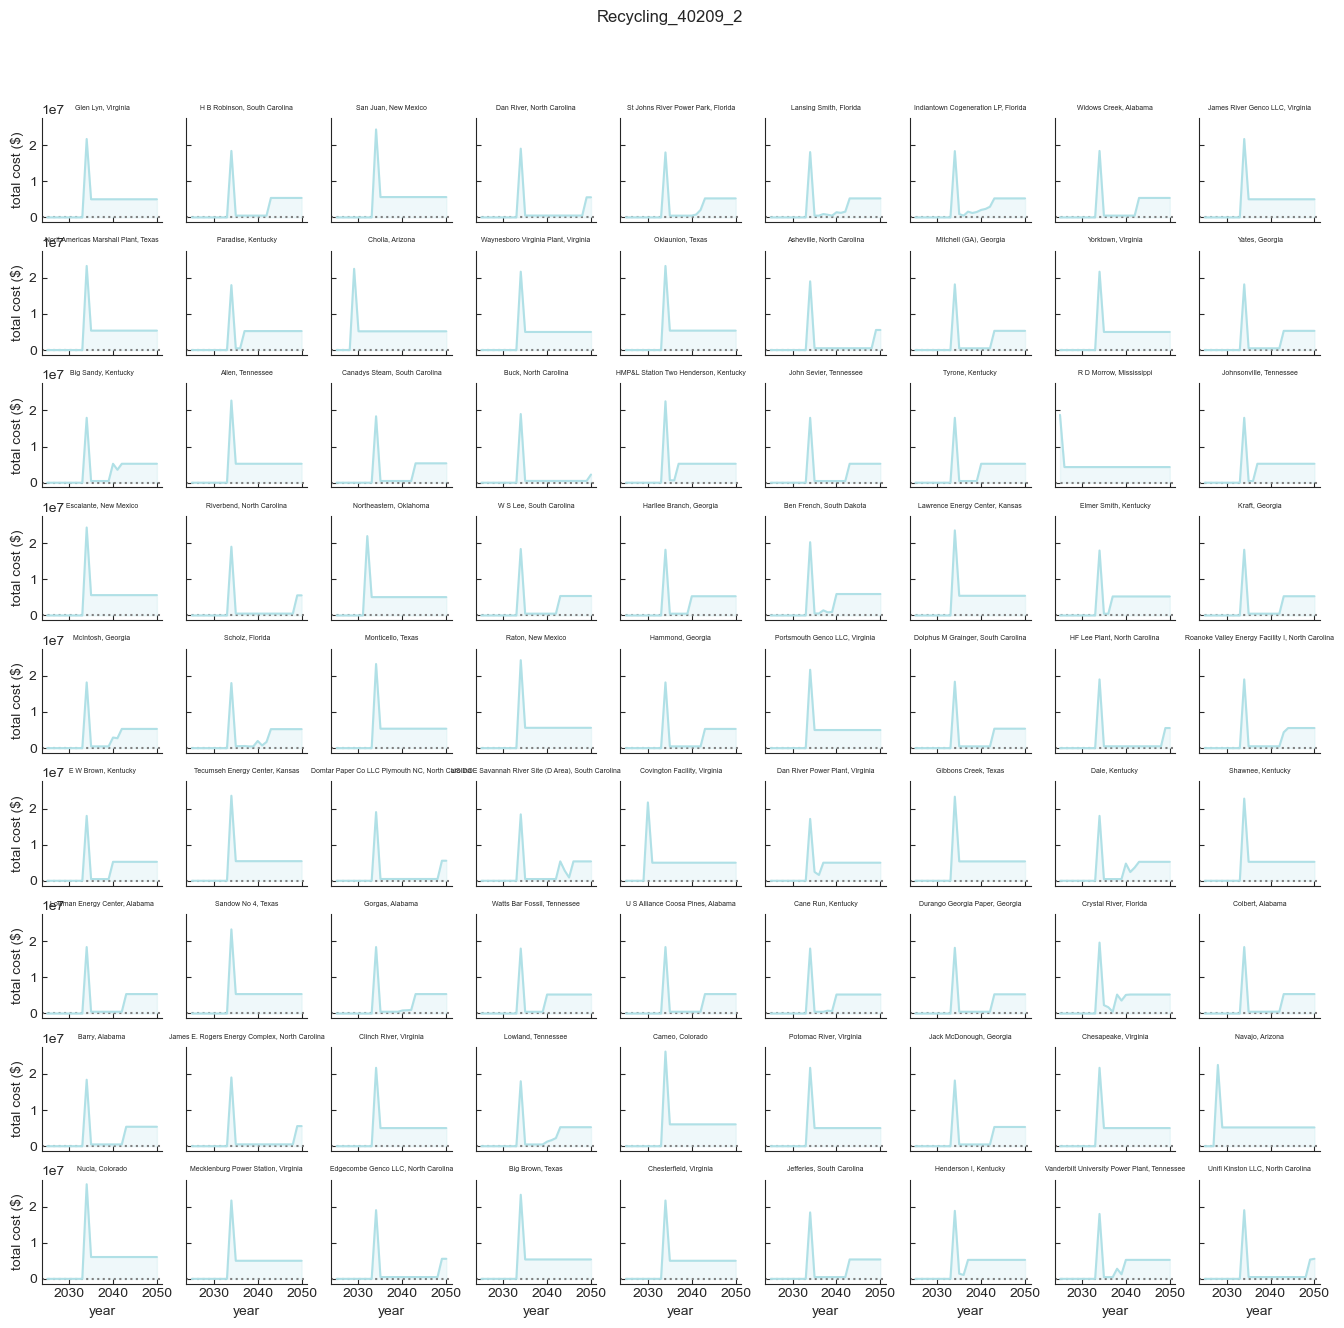

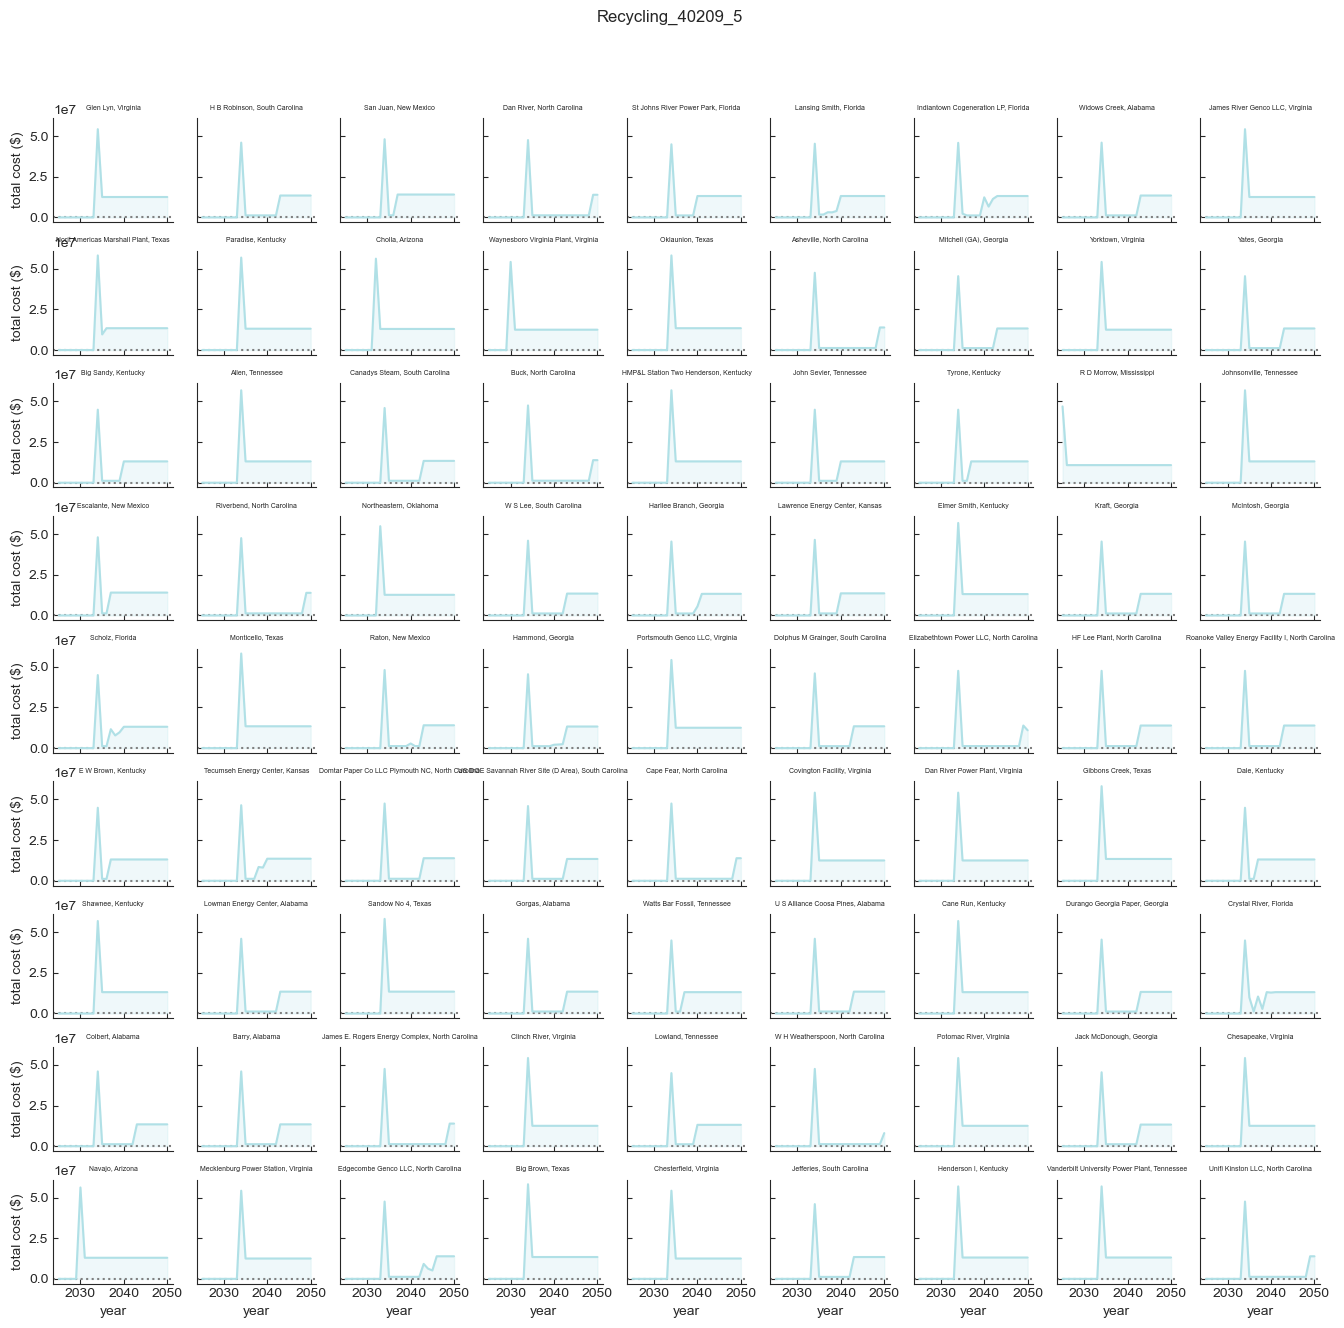

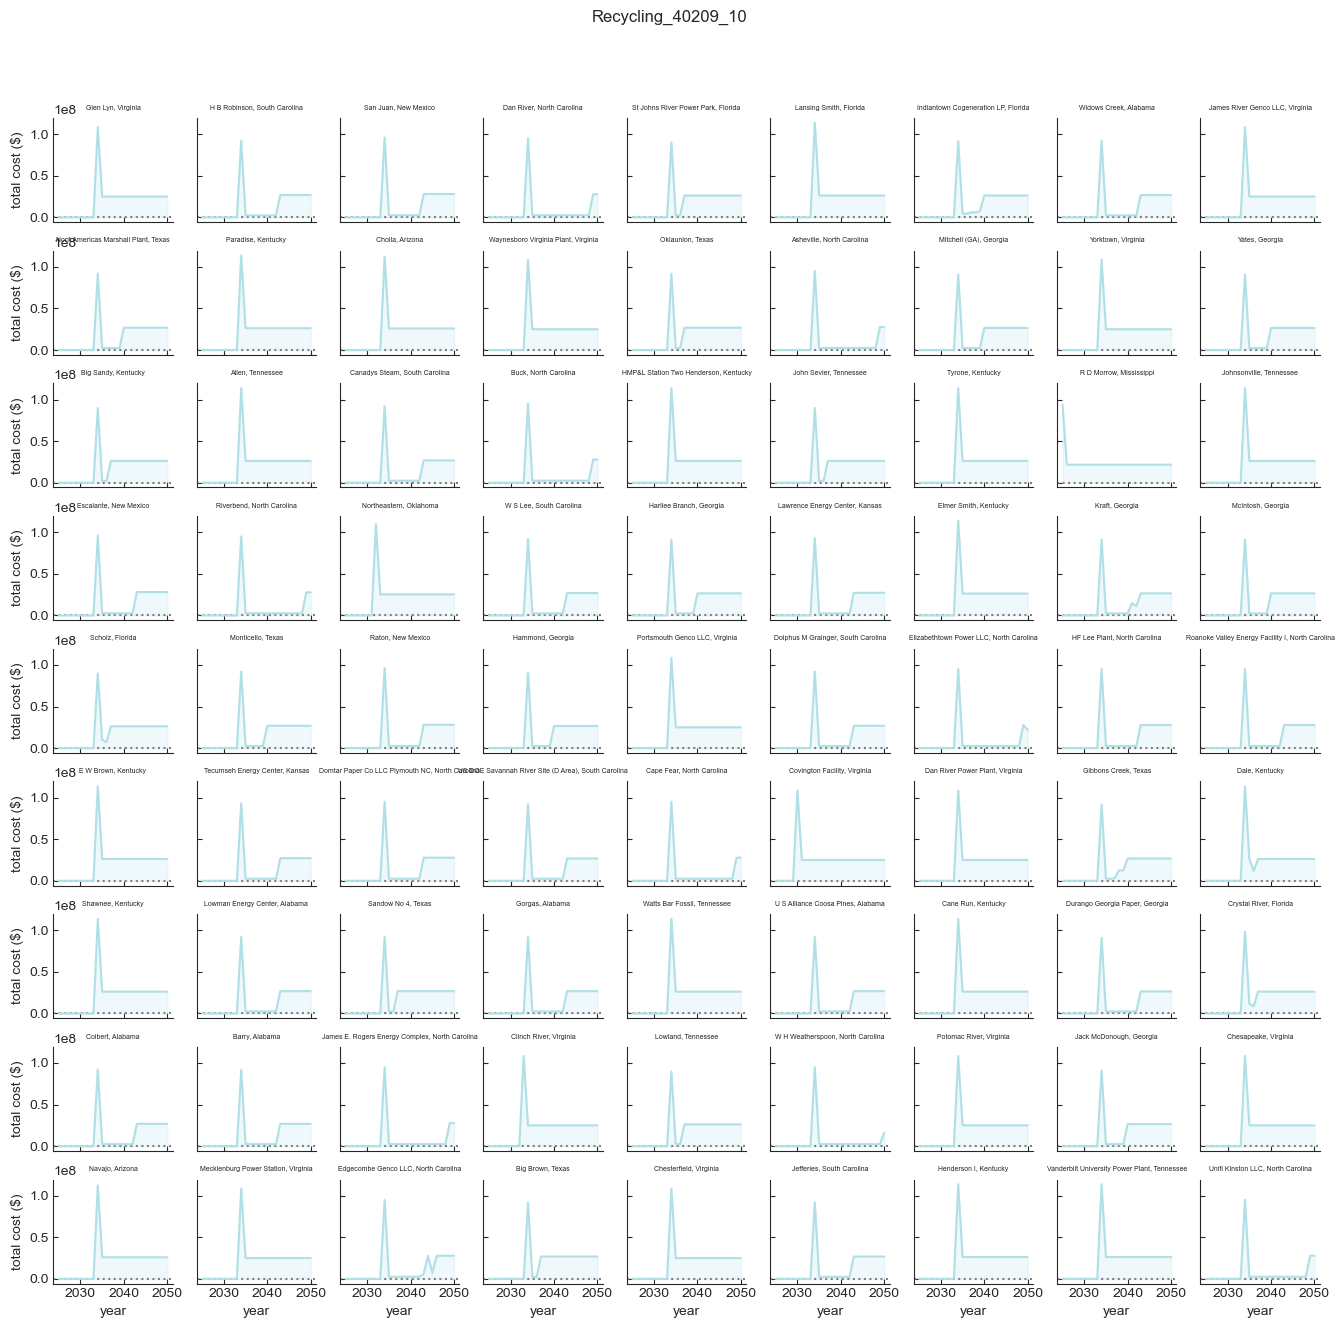

In [35]:
for files in recycling_files_cost:
# Initialize a grid of plots with an Axes for each walk
    grid = sns.FacetGrid(globals()['%s_plants' % (files)], col="location name",
                         col_wrap=9, height=1.5)

    # Draw a horizontal line to show the starting point
    grid.refline(y=0, linestyle=":")


    grid.map(plt.plot, "year", "total cost ($)", color="powderblue")
    grid.map(plt.fill_between, 'year', 'total cost ($)',color= "powderblue", alpha= 0.2)
    # Adjust the tick positions, labels and 
    #sns.set(font_scale=0.1)
    grid.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=5)

    grid.fig.tight_layout(w_pad=1)
    grid.fig.subplots_adjust(top=0.9)
    grid.fig.suptitle(f"{files}")


    plt.savefig(os.path.join(cwd, f"grid_after_update/grid_{files}_cost_totcost.png"), transparent=True);


#### Manufacturing Capacity Utilization Factor

In [ ]:
for files in manufacturing_files_cap:
# Initialize a grid of plots with an Axes for each walk
    grid = sns.FacetGrid(globals()['%s_plants' % (files)], col="location name",
                         col_wrap=9, height=1.5)

    # Draw a horizontal line to show the starting point
    grid.refline(y=0, linestyle=":")


    grid.map(plt.plot, "year", "utilization factor (%)", color='gold')
    grid.map(plt.fill_between, 'year', 'utilization factor (%)',color= "gold", alpha= 0.2)
    # Adjust the tick positions, labels and 
    #sns.set(font_scale=0.1)
    grid.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=5)

    grid.fig.tight_layout(w_pad=1)
    grid.fig.subplots_adjust(top=0.9)
    grid.fig.suptitle(f"{files}")


    plt.savefig(os.path.join(cwd, f"grid_after_update/grid_{files}_cap_uf.png"), transparent=True);


#### Manufacturing Capacity Total Cost

In [ ]:
for files in manufacturing_files_cap:
# Initialize a grid of plots with an Axes for each walk
    grid = sns.FacetGrid(globals()['%s_plants' % (files)], col="location name",
                         col_wrap=9, height=1.5)

    # Draw a horizontal line to show the starting point
    grid.refline(y=0, linestyle=":")


    grid.map(plt.plot, "year", "total cost ($)", color='gold')
    grid.map(plt.fill_between, 'year', 'total cost ($)',color= "gold", alpha= 0.2)

    # Adjust the tick positions, labels and 
    #sns.set(font_scale=0.1)
    grid.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=5)

    grid.fig.tight_layout(w_pad=1)
    grid.fig.subplots_adjust(top=0.9)
    grid.fig.suptitle(f"{files}")


    plt.savefig(os.path.join(cwd, f"grid_after_update/grid_{files}_cap_totcost.png"), transparent=True);


#### Manufacturing Cost Utilization Factor

In [ ]:
for files in manufacturing_files_cost:
# Initialize a grid of plots with an Axes for each walk
# Initialize a grid of plots with an Axes for each walk
    grid = sns.FacetGrid(globals()['%s_plants' % (files)], col="location name",
                         col_wrap=9, height=1.5)

    # Draw a horizontal line to show the starting point
    grid.refline(y=0, linestyle=":")


    grid.map(plt.plot, "year", "utilization factor (%)", color='gold')
    grid.map(plt.fill_between, 'year', 'utilization factor (%)',color= "gold", alpha= 0.2)

    # Adjust the tick positions, labels and 
    #sns.set(font_scale=0.1)
    grid.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=5)

    grid.fig.tight_layout(w_pad=1)
    grid.fig.subplots_adjust(top=0.9)
    grid.fig.suptitle(f"{files}")


    plt.savefig(os.path.join(cwd, f"grid_after_update/grid_{files}_cost_uf.png"), transparent=True);


#### Manufacturing Cost Total Cost

In [ ]:
for files in manufacturing_files_cost:
# Initialize a grid of plots with an Axes for each walk
    grid = sns.FacetGrid(globals()['%s_plants' % (files)], col="location name",
                         col_wrap=9, height=1.5)

    # Draw a horizontal line to show the starting point
    grid.refline(y=0, linestyle=":")


    grid.map(plt.plot, "year", "total cost ($)", color='gold')
    grid.map(plt.fill_between, 'year', 'total cost ($)',color= "gold", alpha= 0.2)

    # Adjust the tick positions, labels and 
    #sns.set(font_scale=0.1)
    grid.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=5)

    grid.fig.tight_layout(w_pad=1)
    grid.fig.subplots_adjust(top=0.9)
    grid.fig.suptitle(f"{files}")


    plt.savefig(os.path.join(cwd, f"grid_after_update/grid_{files}_cost_totcost.png"), transparent=True);


### Map plots

USA map [source2](https://esri.maps.arcgis.com/home/item.html?id=8c2d6d7df8fa4142b0a1211c8dd66903).

In [40]:
import fiona
import geopandas as gp
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import collections
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point, Polygon

%matplotlib inline

#### Load transportation files

##### Recycling cost

In [41]:
for files in recycling_files_cost:
    testfile_path = glob.glob(os.path.join(cwd, "scenarios_after_update", files, 'transportation.csv'))[0]
    globals()['%s_transportation' % (files)] = pd.read_csv(testfile_path) 
    globals()['%s_transportation' % (files)] = globals()['%s_transportation' % (files)].replace({"year": years_dict})

##### Recycling capacity

In [42]:
for files in recycling_files_cap:
    testfile_path = glob.glob(os.path.join(cwd, "scenarios_after_update", files, 'transportation.csv'))[0]
    globals()['%s_transportation' % (files)] = pd.read_csv(testfile_path) 
    globals()['%s_transportation' % (files)] = globals()['%s_transportation' % (files)].replace({"year": years_dict})

##### Manufacturing cost

In [43]:
for files in manufacturing_files_cost:
    testfile_path = glob.glob(os.path.join(cwd, "scenarios_after_update", files, 'transportation.csv'))[0]
    globals()['%s_transportation' % (files)] = pd.read_csv(testfile_path) 
    globals()['%s_transportation' % (files)] = globals()['%s_transportation' % (files)].replace({"year": years_dict})

##### Manufacturing capacity

In [44]:
for files in manufacturing_files_cap:
    testfile_path = glob.glob(os.path.join(cwd, "scenarios_after_update", files, 'transportation.csv'))[0]
    globals()['%s_transportation' % (files)] = pd.read_csv(testfile_path) 
    globals()['%s_transportation' % (files)] = globals()['%s_transportation' % (files)].replace({"year": years_dict})

#### Recycling cost maps

In [ ]:
for files in recycling_files_cost:    
    # Plot base map
    world = gp.read_file(os.path.join(f'resources','USA_States_(Generalized)', 'USA_States_Generalized.shp'))
    world = world.to_crs("EPSG:4326")
    ax = world.plot(color="powderblue", edgecolor="1", figsize=(14, 7))
    ax.set_ylim([23, 50])
    ax.set_xlim([-128, -65])
    plt.axis('off')
    ax.set(title=f'{files}')
    # Draw transportation lines
    data = globals()['%s_transportation' % (files)]
    lines = [
        [
            (
                row["source longitude (deg)"],
                row["source latitude (deg)"],
            ),
            (
                row["destination longitude (deg)"],
                row["destination latitude (deg)"],
            ),
        ]
        for (index, row) in data.iterrows()
    ]
    ax.add_collection(
        collections.LineCollection(
            lines,
            linewidths=0.005,
            zorder=1,
            alpha=0.3,
            color="0.8",
        )
    )

    # Draw source points
    points = gp.points_from_xy(
        data["source longitude (deg)"],
        data["source latitude (deg)"],
    )
    gp.GeoDataFrame(data, geometry=points).plot(ax=ax, color="0.6", markersize=1)

    # Draw destination points
    points = gp.points_from_xy(
        data["destination longitude (deg)"],
        data["destination latitude (deg)"],
    )
    gp.GeoDataFrame(data, geometry=points).plot(ax=ax, markersize=50, color="palevioletred", edgecolor='white')
    
    plt.savefig(os.path.join("maps_after_update",f"map_{files}_cost.png"), transparent=True, dpi=300);
    plt.savefig(os.path.join("maps_after_update",f"map_{files}_cost.pdf"), dpi=300);

#### Recycling capacity maps

In [ ]:
for files in recycling_files_cap:    
    # Plot base map
    world = gp.read_file(os.path.join(f'resources','USA_States_(Generalized)', 'USA_States_Generalized.shp'))
    world = world.to_crs("EPSG:4326")
    ax = world.plot(color="powderblue", edgecolor="1", figsize=(14, 7))
    ax.set_ylim([23, 50])
    ax.set_xlim([-128, -65])
    plt.axis('off')
    ax.set(title=f'{files}')
    # Draw transportation lines
    data = globals()['%s_transportation' % (files)]
    lines = [
        [
            (
                row["source longitude (deg)"],
                row["source latitude (deg)"],
            ),
            (
                row["destination longitude (deg)"],
                row["destination latitude (deg)"],
            ),
        ]
        for (index, row) in data.iterrows()
    ]
    ax.add_collection(
        collections.LineCollection(
            lines,
            linewidths=0.005,
            zorder=1,
            alpha=0.3,
            color="0.8",
        )
    )

    # Draw source points
    points = gp.points_from_xy(
        data["source longitude (deg)"],
        data["source latitude (deg)"],
    )
    gp.GeoDataFrame(data, geometry=points).plot(ax=ax, color="0.6", markersize=1)

    # Draw destination points
    points = gp.points_from_xy(
        data["destination longitude (deg)"],
        data["destination latitude (deg)"],
    )
    gp.GeoDataFrame(data, geometry=points).plot(ax=ax, markersize=50, color="palevioletred", edgecolor='white')
    
    plt.savefig(os.path.join("maps_after_update",f"map_{files}_cap.png"), transparent=True, dpi=300);
    plt.savefig(os.path.join("maps_after_update",f"map_{files}_cap.pdf"), dpi=300);

#### Manufacturing cost maps

In [ ]:
for files in manufacturing_files_cost:    
    # Plot base map
    world = gp.read_file(os.path.join(f'resources','USA_States_(Generalized)', 'USA_States_Generalized.shp'))
    world = world.to_crs("EPSG:4326")
    ax = world.plot(color="gold", edgecolor="1", figsize=(14, 7))
    ax.set_ylim([23, 50])
    ax.set_xlim([-128, -65])
    plt.axis('off')
    ax.set(title=f'{files}')
    # Draw transportation lines
    data = globals()['%s_transportation' % (files)]
    lines = [
        [
            (
                row["source longitude (deg)"],
                row["source latitude (deg)"],
            ),
            (
                row["destination longitude (deg)"],
                row["destination latitude (deg)"],
            ),
        ]
        for (index, row) in data.iterrows()
    ]
    ax.add_collection(
        collections.LineCollection(
            lines,
            linewidths=0.005,
            zorder=1,
            alpha=0.3,
            color="0.8",
        )
    )

    # Draw source points
    points = gp.points_from_xy(
        data["source longitude (deg)"],
        data["source latitude (deg)"],
    )
    gp.GeoDataFrame(data, geometry=points).plot(ax=ax, color="0.6", markersize=1)

    # Draw destination points
    points = gp.points_from_xy(
        data["destination longitude (deg)"],
        data["destination latitude (deg)"],
    )
    gp.GeoDataFrame(data, geometry=points).plot(ax=ax, markersize=50, color="mediumpurple", edgecolor='white')
    
    plt.savefig(os.path.join("maps_after_update",f"map_{files}_cost.png"), transparent=True, dpi=300);
    plt.savefig(os.path.join("maps_after_update",f"map_{files}_cost.pdf"), dpi=300);

#### Manufacturing capacity maps

In [ ]:
for files in manufacturing_files_cap:    
    # Plot base map
    world = gp.read_file(os.path.join(f'resources','USA_States_(Generalized)', 'USA_States_Generalized.shp'))
    world = world.to_crs("EPSG:4326")
    ax = world.plot(color="gold", edgecolor="1", figsize=(14, 7))
    ax.set_ylim([23, 50])
    ax.set_xlim([-128, -65])
    plt.axis('off')
    ax.set(title=f'{files}')
    # Draw transportation lines
    data = globals()['%s_transportation' % (files)]
    lines = [
        [
            (
                row["source longitude (deg)"],
                row["source latitude (deg)"],
            ),
            (
                row["destination longitude (deg)"],
                row["destination latitude (deg)"],
            ),
        ]
        for (index, row) in data.iterrows()
    ]
    ax.add_collection(
        collections.LineCollection(
            lines,
            linewidths=0.005,
            zorder=1,
            alpha=0.3,
            color="0.8",
        )
    )

    # Draw source points
    points = gp.points_from_xy(
        data["source longitude (deg)"],
        data["source latitude (deg)"],
    )
    gp.GeoDataFrame(data, geometry=points).plot(ax=ax, color="0.6", markersize=1)

    # Draw destination points
    points = gp.points_from_xy(
        data["destination longitude (deg)"],
        data["destination latitude (deg)"],
    )
    gp.GeoDataFrame(data, geometry=points).plot(ax=ax, markersize=50, color="mediumpurple", edgecolor='white')
    
    plt.savefig(os.path.join("maps_after_update",f"map_{files}_cap.png"), transparent=True, dpi=300);
    plt.savefig(os.path.join("maps_after_update",f"map_{files}_cap.pdf"), dpi=300);

In [ ]:
# Plot base map
world = gp.read_file(os.path.join(f'resources','USA_States_(Generalized)', 'USA_States_Generalized.shp'))
world = world.to_crs("EPSG:4326")
ax = world.plot(color="gold", edgecolor="1", figsize=(14, 7))
ax.set_ylim([23, 50])
ax.set_xlim([-128, -65])
plt.axis('off')
ax.set(title=f'{files}')
# Draw transportation lines
data = globals()['%s_transportation' % (files)]
lines = [
    [
        (
            row["source longitude (deg)"],
            row["source latitude (deg)"],
        ),
        (
            row["destination longitude (deg)"],
            row["destination latitude (deg)"],
        ),
    ]
    for (index, row) in data.iterrows()
]
ax.add_collection(
    collections.LineCollection(
        lines,
        linewidths=0.005,
        zorder=1,
        alpha=0.3,
        color="0.8",
    )
)

# Draw source points
points = gp.points_from_xy(
    data["source longitude (deg)"],
    data["source latitude (deg)"],
)
gp.GeoDataFrame(data, geometry=points).plot(ax=ax, color="0.6", markersize=1)

# Draw destination points
points = gp.points_from_xy(
    data["destination longitude (deg)"],
    data["destination latitude (deg)"],
)
gp.GeoDataFrame(data, geometry=points).plot(ax=ax, markersize=50, color="palevioletred", edgecolor='white')


### Testing plots

In [ ]:
world = gp.read_file(os.path.join(f'resources','USA_States_(Generalized)', 'USA_States_Generalized.shp'))
world = world.to_crs("EPSG:4326")
ax = world.plot(color="gold", edgecolor="1", figsize=(14, 7))
ax.set_ylim([23, 50])
ax.set_xlim([-128, -65])
plt.axis('off')

In [23]:
Recycling_40209_1_plants.keys()

Index(['plant type', 'location name', 'year', 'latitude (deg)',
       'longitude (deg)', 'capacity (tonne)', 'amount processed (tonne)',
       'amount received (tonne)', 'amount in storage (tonne)',
       'utilization factor (%)', 'energy (GJ)', 'opening cost ($)',
       'expansion cost ($)', 'fixed operating cost ($)',
       'variable operating cost ($)', 'storage cost ($)', 'total cost ($)'],
      dtype='object')

Text(0.5, 0.98, 'Title')

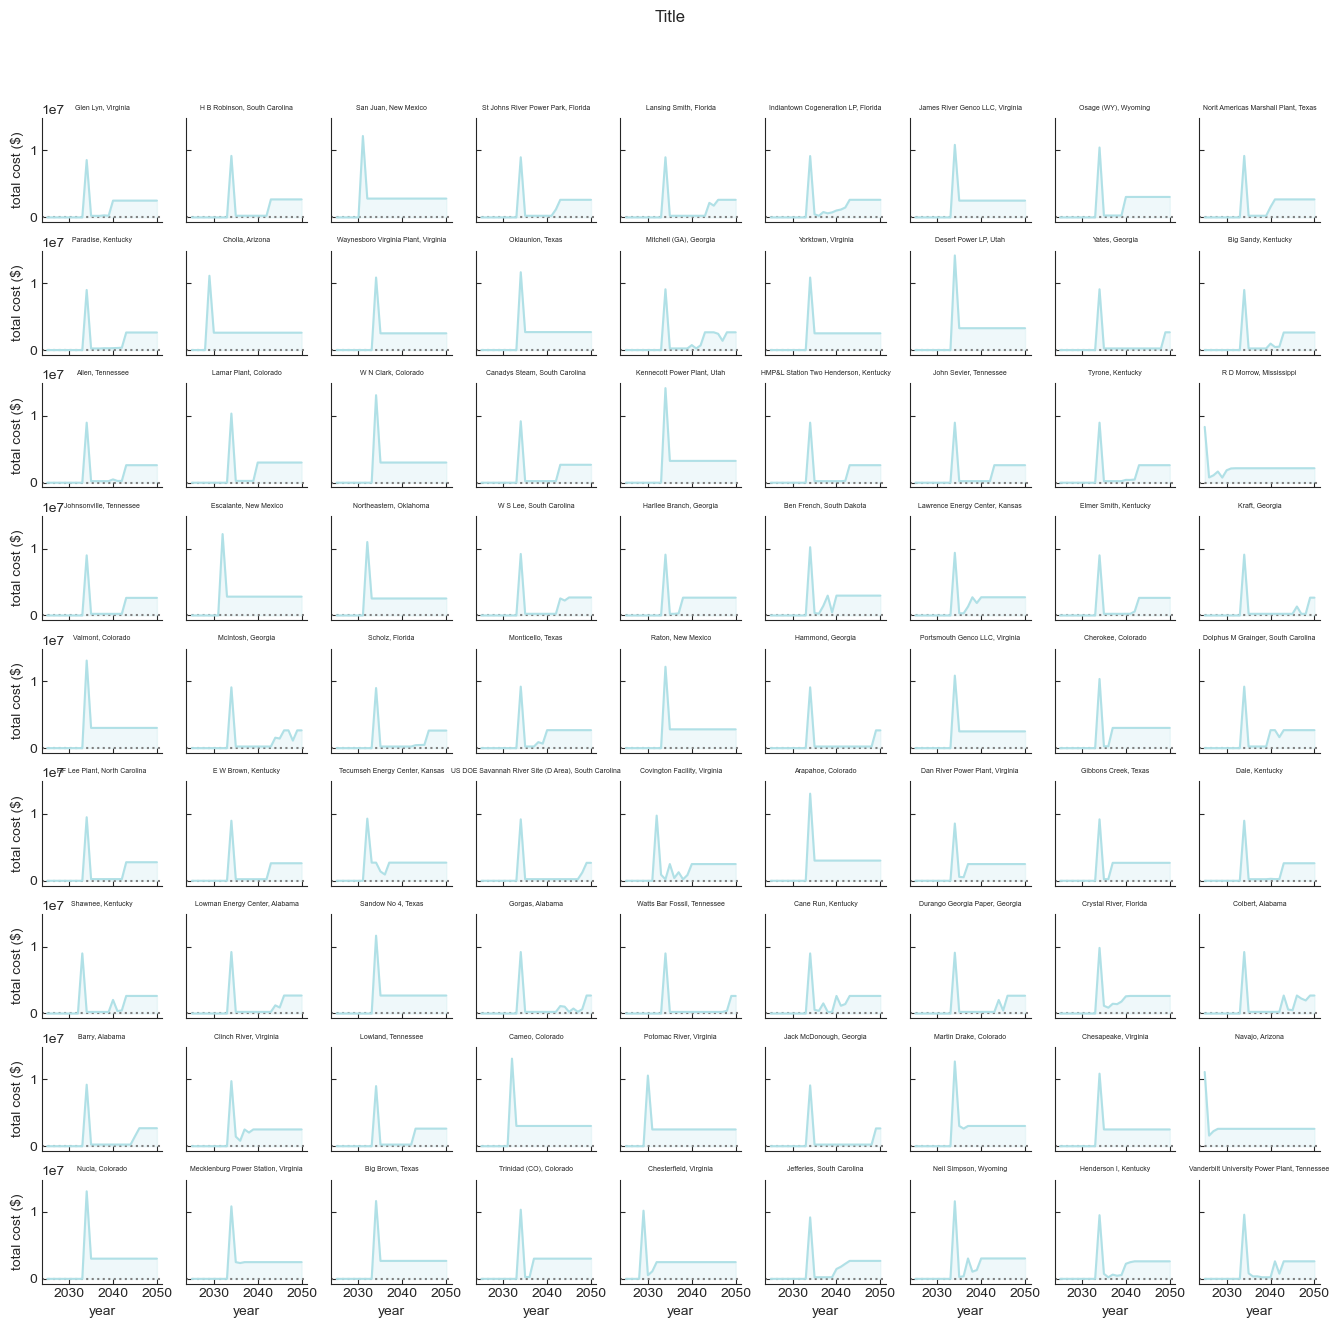

In [30]:
grid = sns.FacetGrid(Recycling_40209_1_plants, col="location name",
                     col_wrap=9, height=1.5)

# Draw a horizontal line to show the starting point
grid.refline(y=0, linestyle=":")


grid.map(plt.plot, "year", 'total cost ($)', color="powderblue")
grid.map(plt.fill_between, 'year', 'total cost ($)',color= "powderblue", alpha= 0.2)
# Adjust the tick positions, labels and 
#sns.set(font_scale=0.1)
grid.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=5)

grid.fig.tight_layout(w_pad=1)
grid.fig.subplots_adjust(top=0.9)
grid.fig.suptitle(f"Title")


#plt.savefig(os.path.join(cwd, f"grid_after_update/grid_{files}_cap_uf.png"), transparent=True);


In [22]:
Recycling_40209_1_plants

plant type                                 location name  year  \
0     PV Recycling Plant                            Glen Lyn, Virginia  2025   
1     PV Recycling Plant                            Glen Lyn, Virginia  2026   
2     PV Recycling Plant                            Glen Lyn, Virginia  2027   
3     PV Recycling Plant                            Glen Lyn, Virginia  2028   
4     PV Recycling Plant                            Glen Lyn, Virginia  2029   
...                  ...                                           ...   ...   
2101  PV Recycling Plant  Vanderbilt University Power Plant, Tennessee  2046   
2102  PV Recycling Plant  Vanderbilt University Power Plant, Tennessee  2047   
2103  PV Recycling Plant  Vanderbilt University Power Plant, Tennessee  2048   
2104  PV Recycling Plant  Vanderbilt University Power Plant, Tennessee  2049   
2105  PV Recycling Plant  Vanderbilt University Power Plant, Tennessee  2050   

      latitude (deg)  longitude (deg)  capacity (tonne)  \
0          37.318072       -80.698321               0.0   
1          37.318072       -80.698321               0.0   
2          37.318072       -80.698321               0.0   
3          37.318072       -80.698321               0.0   
4          37.318072       -80.698321               0.0   
...              ...              ...               ...   
2101       36.169129       -86.784790            7000.0   
2102       36.169129       -86.784790            7000.0   
2103       36.169129       -86.784790            7000.0   
2104       36.169129       -86.784790            7000.0   
2105       36.169129       -86.784790            7000.0   

      amount processed (tonne)  amount received (tonne)  \
0                          0.0                 0.000000   
1                          0.0                 0.000000   
2                          0.0                 0.000000   
3                          0.0                 0.000000   
4                          0.0                 0.000000   
...                        ...                      ...   
2101                    7000.0              6980.157642   
2102                    7000.0              5604.423288   
2103                    7000.0              7000.000000   
2104                    7000.0              7000.000000   
2105                    7000.0              7000.000000   

      amount in storage (tonne)  utilization factor (%)  energy (GJ)  \
0                      0.000000                     NaN     0.000000   
1                      0.000000                     NaN     0.000000   
2                      0.000000                     NaN     0.000000   
3                      0.000000                     NaN     0.000000   
4                      0.000000                     NaN     0.000000   
...                         ...                     ...          ...   
2101                1395.576712                   100.0  6114.408689   
2102                   0.000000                   100.0  4909.306668   
2103                   0.000000                   100.0  6131.790000   
2104                   0.000000                   100.0  6131.790000   
2105                   0.000000                   100.0  6131.790000   

      opening cost ($)  expansion cost ($)  fixed operating cost ($)  \
0                  0.0                 0.0                  0.000000   
1                  0.0                 0.0                  0.000000   
2                  0.0                 0.0                  0.000000   
3                  0.0                 0.0                  0.000000   
4                  0.0                 0.0                  0.000000   
...                ...                 ...                       ...   
2101               0.0                 0.0             236957.446809   
2102               0.0                 0.0             236957.446809   
2103               0.0                 0.0             236957.446809   
2104               0.0                 0.0        